In [1]:
import ipympl
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
import scipy.special
import scipy.optimize
from scipy.optimize import curve_fit
import unyt
print('unyt version: ', unyt.__version__)
import numba
from numba import njit
print('numba version: ', numba.__version__)
import h5py
print('h5py version: ', h5py.__version__)
import struct
import copy

import os,sys

import swiftsimio as sw
print('SwiftSimIO version: ', sw.__version__)
import woma
#print('WoMa version: ', woma.__version__)
from woma.misc import utils, io
from woma.eos import tillotson, sesame, idg, hm80
from woma.eos.T_rho import T_rho
from woma.misc import glob_vars as gv
woma.load_eos_tables()
from HERCULES_structures import *

#this_dir, this_file = os.path.split(__file__)
#path = os.path.join(this_dir)
#sys.path.append(path)
#import gadget_sph

R_earth = gv.R_earth #6.371e6   # m
M_earth = gv.M_earth #5.9724e24  # kg 
G = 6.67408e-11  # m^3 kg^-1 s^-2
LEM=3.5E34 #AMof Earth-Moon system in mks

mant_mat_id = 403 #USER INPUT
core_mat_id = 402 #USER INPUT

def erfcfn(x, mFL, a, b):
    return mFL*scipy.special.erfc((x-a)/(b*np.sqrt(2)))

def arctanfn(x,a,b):
    return .5-np.arctan((x-a)/(b*np.pi))/(np.pi)

def quadlogfn(x, a, b, c, z):
    return z-10.**(a*(x**2)+b*x+c)

def quadlogfnsimple(x, a, b, c):
    return 10.**(a*(x**2)+b*x+c)

def quadlogfnfull(x, a2,a1,a0, b2,b1,b0, c2,c1,c0, z2,z1,z0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**(z2*ytheta**2+z1*ytheta+z0)-10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

def quadlogfnfull2(xQS,ytheta, a2,a1,a0, b2,b1,b0, c2,c1,c0, z2,z1,z0):
    return 10.**(z2*(ytheta**2)+z1*ytheta+z0)-10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

vquadlogfnfull=np.vectorize(quadlogfnfull2,excluded=[2,3,4,5,6,7,8,9,10,11,12,13])

def Tlogfnfull(x, a2,a1,a0,b2,b1,b0,c2,c1,c0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

def Tlogfnlinear(x, a1,a0,b1,b0,c1,c0):
    return Tlogfnfull(x, 0,a1,a0,0,b1,b0,0,c1,c0)

def Tlogfnfull2(xQS,ytheta, a2,a1,a0,b2,b1,b0,c2,c1,c0):
    return 10.**((a2*ytheta**2+a1*ytheta+a0)*xQS**2+(b2*ytheta**2+b1*ytheta+b0)*xQS+(c2*ytheta**2+c1*ytheta+c0))

vTlogfnfull=np.vectorize(Tlogfnfull2,excluded=[2,3,4,5,6,7,8,9,10])

def coreTlogfnfull(x, a3,a2,a1,a0,b3,b2,b1,b0):
    if np.shape(x)!=(2,):
        xQS=x[:,0]
        ytheta=x[:,1]
    else:
        xQS=x[0]
        ytheta=x[1]
    return 10.**((a3*ytheta**3+a2*ytheta**2+a1*ytheta+a0)*xQS+(b3*ytheta**3+b2*ytheta**2+b1*ytheta+b0))

def coreTlogfnfull2(xQS,ytheta, a3,a2,a1,a0,b3,b2,b1,b0):
    return 10.**((a3*ytheta**3+a2*ytheta**2+a1*ytheta+a0)*xQS+(b3*ytheta**3+b2*ytheta**2+b1*ytheta+b0))

vcoreTlogfnfull=np.vectorize(coreTlogfnfull2,excluded=[2,3,4,5,6,7,8,9])

def blackbody(x, a, b):
    return (a*(x)**3/(np.exp(b*(x))-1))

print(.5-np.arctan(100)/(np.pi))
markers=['o','P','x','*','^','s','p','h','v','D','d']

def find_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    #ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

    return ci

unyt version:  v2.8.0
numba version:  0.59.1
h5py version:  3.6.0
SwiftSimIO version:  5.0.1
0.003182992764908188


In [2]:
#print(plt.rcParams.keys())
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
#matplotlib.rc('xlabel', fontsize=14)
#matplotlib.rc('ylabel', fontsize=14)
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["figure.facecolor"] = 'white'
#mpl.rcParams["axes.facecolor"] 
plt.rcParams["savefig.facecolor"]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize':14})

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [3]:
# this cell has a java script that that enables hiding the raw python code
# test typing

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def calcK(startProfile):
    [r0cgs,rho0cgs,T0,P0cgs,u0cgs,s0cgs,menclosedcgs,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
    r0=r0cgs/1.e2
    menclosed=menclosedcgs/1.e3
    Mt=menclosed[-1]
    Rt=r0[-1]
    Ishell=np.zeros(np.size(r0))
    for i in range(1,np.size(r0)):
        Ishell[i]=(2/5)*(menclosed[i]-menclosed[i-1])*(r0[i]**5-r0[i-1]**5)/(r0[i]**3-r0[i-1]**3)
    Itot=np.sum(Ishell,dtype='float64')
    K=Itot/Mt/(Rt**2)
    return K

In [5]:
def CMB_rubie(mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    return np.power(mcore*R_earth/(4/3*np.pi*rhocore*R_earth),1/3)
vCMB_rubie=np.vectorize(CMB_rubie)

def P_rubie(r,rCMB,rplanet,mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    b = np.power(mcore/(4/3*np.pi*rhocore),1/3)
    a = np.power((mmantle+4/3*rhomant*np.pi*b**3)/(4/3*np.pi*rhomant),1/3)
    #a = np.power(mplanet*M_earth/(4/3*np.pi*(1-(rhomant/7/(rhocore/3+rhomant/7))*(rhocore-rhomant))),1/3)
    #b = rplanet*R_earth*np.power(4/7*rhomant/(4/3*rhocore + 4/7*rhomant),1/3)
    #a = rplanet*R_earth
    #b = rCMB*R_earth
    if (r<=a and r>=b):
        return 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/r-1/a) + 2/3*np.pi*G*rhomant**2*(a**2-r**2)
    if (r>0 and r<b):
        return 2/3*np.pi*G*rhocore**2*(b**2-r**2) + 2/3*np.pi*G*rhomant**2*(a**2-b**2) + 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/b-1/a)
vP_rubie=np.vectorize(P_rubie)

def T_rubie(P):
    P=P/1.e9
    if P<24:
        return 1874 + 55.43*P - 1.74*P**2 + 0.0193*P**3
    if P>=24:
        return 1249 + 58.28*P - 0.395*P**2 + 0.0011*P**3

class simdata(object):
    def __init__(self,basename,label='',M_t=1,M_i=1,R_t=1,R_i=1,vi=1,theta=45,startProfile='',verbose=False):
        self.basename=basename
        self.M_t = M_t
        self.M_i = M_i
        self.R_t = R_t
        self.R_i = R_i
        self.vi = vi
        self.theta = theta
        self.b=np.sin(self.theta*np.pi/180)
        self.B=(self.R_t+self.R_i)*np.sin(self.theta*np.pi/180)
        if os.path.isfile(basename+'_data.txt'):
            file_suffix='_data.txt'
        elif os.path.isfile(basename+'_data_last.txt'):
            file_suffix='_data_last.txt'
        [self.Lztot,
        self.Lzbnd,
        self.Lzplanet,
        self.Lzdisk,
        self.Lw0tot,
        self.Lw0bnd,
        self.Lw0planet,
        self.Lw0disk,
        self.Ntot,
        self.Nbound,
        self.Nplanet,
        self.Ndisk,
        self.Nmantle,
        self.Ncore,
        self.Mbound,
        self.Mplanet,
        self.Mdisk,
        self.Mmantle,
        self.Mcore,
        self.KEtot,
        self.KEbnd,
        self.KEplanet,
        self.KEdisk,
        self.KEmantle,
        self.KEcore,
        self.IEtot,
        self.IEbnd,
        self.IEplanet,
        self.IEdisk,
        self.IEmantle,
        self.IEcore,
        self.GPEtot,
        self.GPEbnd,
        self.GPEplanet,
        self.GPEdisk,
        self.GPEmantle,
        self.GPEcore,
        self.PGPEtot,
        self.PGPEbnd,
        self.PGPEplanet,
        self.PGPEdisk,
        self.PGPEmantle,
        self.PGPEcore,
        self.Etot,
        self.Ebnd,
        self.Eplanet,
        self.Edisk,
        self.Emantle,
        self.Ecore,
        self.Nh_maxtot,
        self.Nh_maxbound,
        self.Nlost,
        self.KElost,
        self.IElost,
        self.GPElost,
        self.PGPElost,
        self.Elost,
        self.Etot_adjusted,
        Etot0arr,
        Ntot0arr,
        self.time,
        GPEminarr] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_mantle_profiles.txt'):
            file_suffix='_mantle_profiles.txt'
        [self.RRRmant,
        self.RRR50mant,
        self.RRmant, 
        self.RR50mant,
        self.U25mant,
        self.U50mant,
        self.U75mant,
        self.Umeanmant,
        self.U25meanmant,
        self.U75meanmant,
        self.deltaU25mant,
        self.deltaU50mant,
        self.deltaU75mant,
        self.deltaUmeanmant,
        self.deltaU25meanmant,
        self.deltaU75meanmant,
        self.S25mant,
        self.S50mant,
        self.S75mant,
        self.Smeanmant,
        self.S25meanmant,
        self.S75meanmant,
        self.deltaS25mant,
        self.deltaS50mant,
        self.deltaS75mant,
        self.deltaSmeanmant,
        self.deltaS25meanmant,
        self.deltaS75meanmant,
        self.T25mant,
        self.T50mant,
        self.T75mant,
        self.Tmeanmant,
        self.T25meanmant,
        self.T75meanmant,
        self.deltaT25mant,
        self.deltaT50mant,
        self.deltaT75mant,
        self.deltaTmeanmant,
        self.deltaT25meanmant,
        self.deltaT75meanmant,
        self.P25mant,
        self.P50mant,
        self.P75mant,
        self.Pmeanmant,
        self.P25meanmant,
        self.P75meanmant,
        self.deltaP25mant,
        self.deltaP50mant,
        self.deltaP75mant,
        self.deltaPmeanmant,
        self.deltaP25meanmant,
        self.deltaP75meanmant,
        self.rho25mant,
        self.rho50mant,
        self.rho75mant,
        self.rhomeanmant,
        self.rho25meanmant,
        self.rho75meanmant] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_core_profiles.txt'):
            file_suffix='_core_profiles.txt'
        [self.RRRcore,
        self.RRR50core,
        self.RRcore, 
        self.RR50core,
        self.U25core,
        self.U50core,
        self.U75core,
        self.Umeancore,
        self.U25meancore,
        self.U75meancore,
        self.deltaU25core,
        self.deltaU50core,
        self.deltaU75core,
        self.deltaUmeancore,
        self.deltaU25meancore,
        self.deltaU75meancore,
        self.S25core,
        self.S50core,
        self.S75core,
        self.Smeancore,
        self.S25meancore,
        self.S75meancore,
        self.deltaS25core,
        self.deltaS50core,
        self.deltaS75core,
        self.deltaSmeancore,
        self.deltaS25meancore,
        self.deltaS75meancore,
        self.T25core,
        self.T50core,
        self.T75core,
        self.Tmeancore,
        self.T25meancore,
        self.T75meancore,
        self.deltaT25core,
        self.deltaT50core,
        self.deltaT75core,
        self.deltaTmeancore,
        self.deltaT25meancore,
        self.deltaT75meancore,
        self.P25core,
        self.P50core,
        self.P75core,
        self.Pmeancore,
        self.P25meancore,
        self.P75meancore,
        self.deltaP25core,
        self.deltaP50core,
        self.deltaP75core,
        self.deltaPmeancore,
        self.deltaP25meancore,
        self.deltaP75meancore,
        self.rho25core,
        self.rho50core,
        self.rho75core,
        self.rhomeancore,
        self.rho25meancore,
        self.rho75meancore] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        corecore = np.where(self.RRRcore<self.RRRmant[0])
        if os.path.isfile(basename+'_miscibility.txt'):
            file_suffix='_miscibility.txt'
        [self.miscMtot,
        self.miscMmant,
        self.miscMcore,
        self.miscmantfrac,
        self.misccorefrac] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_pressure_profiles.txt'):
            file_suffix='_pressure_profiles.txt'
        [self.radiusmeanPlist,
        self.P25profile,
        self.P50profile,
        self.P75profile,
        self.P25model,
        self.P50model,
        self.P75model] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if (startProfile!='') & os.path.isfile(startProfile):
            [r0cgs,rho0cgs,self.T0,P0cgs,u0cgs,s0cgs,menclosed,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
            self.r0=r0cgs/1.e2
            self.rho0=rho0cgs*1.e3
            self.P0=P0cgs/10
            self.u0=u0cgs/1.e4
            self.s0=s0cgs/1.e4
            coreidx0=np.where(matID0==402)
            mantidx0=np.where(matID0==403)
            self.PCMB0=(self.P0[mantidx0][0]+self.P0[coreidx0][-1])/2
            self.TCMB0mant=self.T0[mantidx0][0]
            self.TCMB0core=self.T0[coreidx0][-1]
            self.K = calcK(startProfile)
            self.Lzstar=self.K*(self.M_t*M_earth)*(self.R_t*R_earth)**2*np.sqrt(G*(self.M_t*M_earth)/(self.R_t*R_earth)**3)/LEM
        self.P25profileCMB = self.P25profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P50profileCMB = self.P50profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P75profileCMB = self.P75profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.TCMB25 = self.T25mant[0]
        self.TCMB50 = self.T50mant[0]
        self.TCMB75 = self.T75mant[0]
        self.TCMBmean = self.Tmeanmant[0]
        self.TCMB25mean = self.T25meanmant[0]
        self.TCMB75mean = self.T75meanmant[0]
        self.PCMB25 = (self.P25mant[0]+self.P25core[corecore][-1])/2
        self.PCMB50 = (self.P50mant[0]+self.P50core[corecore][-1])/2
        self.PCMB75 = (self.P75mant[0]+self.P75core[corecore][-1])/2
        self.PCMBmean = (self.Pmeanmant[0]+self.Pmeancore[corecore][-1])/2
        self.PCMB25mean = (self.P25meanmant[0]+self.P25meancore[corecore][-1])/2
        self.PCMB75mean = (self.P75meanmant[0]+self.P75meancore[corecore][-1])/2
        self.CMBrubie = CMB_rubie(self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.CMBrubieFF = CMB_rubie(self.Mplanet[-1],0.3*self.Mplanet[-1]*M_earth,0.7*self.Mplanet[-1]*M_earth)
        self.P_CMBrubie = P_rubie(self.CMBrubie,self.CMBrubie,0,self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.P_CMBrubieFF = P_rubie(self.CMBrubieFF,self.CMBrubieFF,0,self.Mplanet[-1],0.3*self.Mplanet[-1]*M_earth,0.7*self.Mplanet[-1]*M_earth)
        self.T_CMBrubie = T_rubie(self.P_CMBrubie)
        if os.path.isfile(basename+'_final'):
            self.HERCparams=HERCULES_parameters()
            self.HERCp=HERCULES_planet()
            with open(basename+'_final', "rb") as file:
                self.HERCparams.read_binary(file)
                self.HERCp.read_binary(file)
            self.HERCp.calc_pCMB()
            self.HERC_PCMB = self.HERCp.pCMB
            self.HERC_Lz = np.abs(self.HERCp.Lout[-1]/LEM)
            self.HERC_r=np.array([])
            self.HERC_P=np.array([])
            for i in range(self.HERCp.Nlayer):
                self.HERC_r = np.append(self.HERC_r,self.HERCp.layers[-1-i].a)
                self.HERC_P = np.append(self.HERC_P,self.HERCp.press[-1-i])
        else:
            self.HERC_PCMB = float('nan')
            self.HERC_Lz = self.Lzbnd[-1]
            self.HERC_r = np.full(2,float('nan'))
            self.HERC_P = np.full(2,float('nan'))
        if os.path.isfile(basename+'_phase_data.txt'):
            file_suffix='_phase_data.txt'
        [self.Phase,
         self.NmantPhase,
         self.NmantPhaseFrac,
         self.MmantPhase,
         self.MmantPhaseFrac,
         self.RRRminmantPhase,
         self.RRRminmantEqPhase,
         self.RRRmaxmantPhase,
         self.RRRmaxmantEqPhase,
         self.NcorePhase,
         self.NcorePhaseFrac,
         self.McorePhase,
         self.McorePhaseFrac,
         self.RRRmincorePhase,
         self.RRRmaxcorePhase]=np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        self.RRRminmantPhase=self.RRRminmantPhase/R_earth
        self.RRRmincorePhase=self.RRRmincorePhase/R_earth
        self.RRRmaxmantPhase=self.RRRmaxmantPhase/R_earth
        self.RRRmaxcorePhase=self.RRRmaxcorePhase/R_earth
        self.Etot0 = Etot0arr[0]
        self.Ntot0 = Ntot0arr[0]
        self.GPEmin = GPEminarr[0]
        self.Nsnap = np.size(self.time)
        self.B_crit=self.R_t/(self.R_t+self.R_i)
        self.theta_crit=np.arcsin(self.R_t/(self.R_t+self.R_i))
        self.label=label
        self.QR = self.QRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.vi)
        self.QprimeR = self.QprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QS = self.QSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        if verbose: print(self.label,self.QS/1.e6)
        self.QstarprimeR = self.QstarprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QstarS = self.QstarSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i)
        self.QstarSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i,star=True)
        self.outcomemarker = 'o'
        anglelist = [0,10,20,30,45,60,75,89.7]
        for i in range(np.size(anglelist)):
            if self.theta==anglelist[i]:
                self.thetamarker=markers[i]
        mtarglist = [0.01,0.1,0.5,0.91,1.3]
        for i in range(np.size(mtarglist)):
            if np.abs(self.M_t-mtarglist[i])/mtarglist[i]<0.05:
                self.sizemarker=markers[i]
        mratiolist = [2,3,6]
        for i in range(np.size(mratiolist)):
            if np.abs((self.M_t/self.M_i)-mratiolist[i])/mratiolist[i]<0.05:
                self.ratiomarker=markers[i]
            
    def fP_T(self,fP):
        fracP = self.PCMBmean*fP
        fracR = self.radiusmeanPlist[np.where(self.Pmeanmant<fracP)][0]
        fracT = self.Tmeanmant[np.where(self.RRRmant>fracR)][0]
        return fracT
    
    def QRfn(self,M_t,M_i,R_t,R_i,Vi,):
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        return 0.5*mu*v_imp**2/Mtot
    
    def QprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        #if theta>np.pi/3:
        #    theta=theta/1.035
        #    B=(R_t+R_i)*np.sin(theta)
        #    l = R_t+R_i-B
        #    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)*self.QR
    
    def QSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QprimeR*(1+M_i/M_t)*(1-b)
    
    def QstarprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        mubar = 0.35
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)**(2-3*mubar/2)*self.QR
    
    def QstarSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QstarprimeR*(1+M_i/M_t)*(1-b)
        
    def QSstandardfn(self,M_t,M_i,R_t,R_i,theta=30.,Vi=1.0,star=False):
        theta=theta*np.pi/180
        b=np.sin(theta)
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        QR=0.5*mu*v_imp**2/Mtot
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        QprimeR=(mu/mua)*QR
        if star:
            mubar = 0.35
            QstarprimeR=(mu/mua)**(2-3*mubar/2)*self.QR
            return QstarprimeR*(1+M_i/M_t)*(1-b)
        return QprimeR*(1+M_i/M_t)*(1-b)
    
def QS(M_t,M_i,R_t,R_i,Vi,theta,square=False):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    v_imp = Vi*v_esc
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QR=0.5*mu*v_imp**2/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeR=(mu/mua)*QR
    b=np.sin(theta)
    if square:
        return QprimeR*(1+M_i/M_t)**2*(1-b)
    return QprimeR*(1+M_i/M_t)*(1-b)

def QS_theta_v(M_t,M_i,R_t,R_i,theta,Vi0,theta0,square=False):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QRnov=0.5*mu/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeRnov=(mu/mua)*QRnov
    b=np.sin(theta)
    if square:
        QSnov=QprimeRnov*(1+M_i/M_t)**2*(1-b)
    else:
        QSnov=QprimeRnov*(1+M_i/M_t)*(1-b)
    return np.sqrt(QS(M_t/M_earth,M_i/M_earth,R_t/R_earth,R_i/R_earth,Vi0,theta0)/QSnov)/v_esc

In [6]:
moon01x005v1th20 = simdata('./data/moon0.01x.005v1th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=20)
moon01x005v115th20 = simdata('./data/moon0.01x.005v1.15th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=20)
moon01x005v15th20 = simdata('./data/moon0.01x.005v1.5th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=20)
moon01x005v20th20 = simdata('./data/moon0.01x.005v2.0th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=20)
moon01x005th20list=[moon01x005v1th20,moon01x005v115th20,moon01x005v15th20,moon01x005v20th20]
moon01x005v1th30 = simdata('./data/moon0.01x.005v1th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=30)
moon01x005v115th30 = simdata('./data/moon0.01x.005v1.15th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=30)
moon01x005v145th30 = simdata('./data/moon0.01x.005v1.45th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.45th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.45,theta=30)
moon01x005v15th30 = simdata('./data/moon0.01x.005v1.5th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=30)
moon01x005v20th30 = simdata('./data/moon0.01x.005v2.0th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=30)
moon01x005th30list=[moon01x005v1th30,moon01x005v115th30,moon01x005v15th30,moon01x005v20th30,moon01x005v145th30]
moon01x005v1th45 = simdata('./data/moon0.01x.005v1th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=45)
moon01x005v115th45 = simdata('./data/moon0.01x.005v1.15th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=45)
moon01x005v135th45 = simdata('./data/moon0.01x.005v1.35th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.35th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.35,theta=45)
moon01x005v15th45 = simdata('./data/moon0.01x.005v1.5th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=45)
moon01x005v20th45 = simdata('./data/moon0.01x.005v2.0th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=45)
moon01x005th45list=[moon01x005v1th45,moon01x005v115th45,moon01x005v15th45,moon01x005v20th45,moon01x005v135th45]
moon01x005v1th60 = simdata('./data/moon0.01x.005v1th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=60)
moon01x005v105th60 = simdata('./data/moon0.01x.005v1.05th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=60)
moon01x005v115th60 = simdata('./data/moon0.01x.005v1.15th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=60)
moon01x005v15th60 = simdata('./data/moon0.01x.005v1.5th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=60)
moon01x005v20th60 = simdata('./data/moon0.01x.005v2.0th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=60)
moon01x005th60list=[moon01x005v1th60,moon01x005v115th60,moon01x005v15th60,moon01x005v20th60,moon01x005v105th60]
moon01x005v1th75 = simdata('./data/moon.01x.005v1th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=75)
moon01x005v1025th75 = simdata('./data/moon.01x.005v1.025th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.025,theta=75)
moon01x005v105th75 = simdata('./data/moon.01x.005v1.05th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=75)
moon01x005v11th75 = simdata('./data/moon.01x.005v1.1th75',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.1,theta=75)
moon01x005th75list=[moon01x005v1th75,moon01x005v1025th75,moon01x005v11th75,moon01x005v105th75]
moon01x005v1th897 = simdata('./data/moon.01x.005v1th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=89.7)
moon01x005v1025th897 = simdata('./data/moon.01x.005v1.025th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.025,theta=89.7)
moon01x005v105th897 = simdata('./data/moon.01x.005v1.05th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.05,theta=89.7)
moon01x005th897list=[moon01x005v1th897,moon01x005v1025th897]#,moon01x005v105th897
moon01x005v1th0 = simdata('./data/moon0.01x.005v1th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=0)
moon01x005v15th0 = simdata('./data/moon0.01x.005v1.5th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=0)
moon01x005v20th0 = simdata('./data/moon0.01x.005v2.0th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th10',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=0)
moon01x005v115th10 = simdata('./data/moon0.01x.005v1.15th10',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th10',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=10)
moon01x005v115th0 = simdata('./data/moon0.01x.005v1.15th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=0)
moon01x005th010list=[moon01x005v115th10,moon01x005v1th0,moon01x005v115th0,moon01x005v15th0,moon01x005v20th0]
print('Target K: ',moon01x005v1th30.K)
print('Target L*: ',moon01x005v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [7]:
mars01x05v1th0 = simdata('./data/mars0.1x.05v1th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=0)
mars01x05v115th0 = simdata('./data/mars0.1x.05v1.15th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=0)
mars01x05v15th0 = simdata('./data/mars0.1x.05v1.5th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=0)
mars01x05v20th0 = simdata('./data/mars0.1x.05v2.0th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=0)
mars01x05th0list=[mars01x05v1th0,mars01x05v115th0,mars01x05v15th0,mars01x05v20th0]
mars01x05v1th20 = simdata('./data/mars0.1x.05v1th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=20)
mars01x05v115th20 = simdata('./data/mars0.1x.05v1.15th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=20)
mars01x05v15th20 = simdata('./data/mars0.1x.05v1.5th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=20)
mars01x05v20th20 = simdata('./data/mars0.1x.05v2.0th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=20)
mars01x05th20list=[mars01x05v1th20,mars01x05v115th20,mars01x05v15th20,mars01x05v20th20]
mars01x05v1th30 = simdata('./data/mars0.1x.05v1th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=30)
mars01x05v115th30 = simdata('./data/mars0.1x.05v1.15th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=30)
mars01x05v145th30 = simdata('./data/mars0.1x.05v1.45th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.45th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.45,theta=30)
mars01x05v15th30 = simdata('./data/mars0.1x.05v1.5th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=30)
mars01x05v20th30 = simdata('./data/mars0.1x.05v2.0th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=30)
mars01x05th30list=[mars01x05v1th30,mars01x05v115th30,mars01x05v15th30,mars01x05v20th30,mars01x05v145th30]
mars01x05v1th45 = simdata('./data/mars0.1x.05v1th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=45)
mars01x05v115th45 = simdata('./data/mars0.1x.05v1.15th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=45)
mars01x05v135th45 = simdata('./data/mars0.1x.05v1.35th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.35th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.35,theta=45)
mars01x05v15th45 = simdata('./data/mars0.1x.05v1.5th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=45)
mars01x05v20th45 = simdata('./data/mars0.1x.05v2.0th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=45)
mars01x05th45list=[mars01x05v1th45,mars01x05v115th45,mars01x05v15th45,mars01x05v20th45,mars01x05v135th45]
mars01x05v1th60 = simdata('./data/mars0.1x.05v1th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=60)
mars01x05v105th60 = simdata('./data/mars0.1x.05v1.05th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=60)
mars01x05v115th60 = simdata('./data/mars0.1x.05v1.15th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=60)
mars01x05v15th60 = simdata('./data/mars0.1x.05v1.5th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=60)
mars01x05v20th60 = simdata('./data/mars0.1x.05v2.0th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=60)
mars01x05th60list=[mars01x05v1th60,mars01x05v115th60,mars01x05v15th60,mars01x05v20th60,mars01x05v105th60]
mars01x05v1th75 = simdata('./data/mars0.1x.05v1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=75)
mars01x05v1025th75 = simdata('./data/mars0.1x.05v1.025th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.025,theta=75)
mars01x05v105th75 = simdata('./data/mars0.1x.05v1.05th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=75)
mars01x05v11th75 = simdata('./data/mars0.1x.05v1.1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.1,theta=75)
mars01x05th75list = [mars01x05v1th75,mars01x05v1025th75,mars01x05v105th75,mars01x05v11th75]
mars01x05v1th897 = simdata('./data/mars0.1x.05v1th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=89.7)
mars01x05v1025th897 = simdata('./data/mars0.1x.05v1.025th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.025,theta=89.7)
mars01x05v105th897 = simdata('./data/mars0.1x.05v1.05th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=89.7)
mars01x05th897list = [mars01x05v1th897,mars01x05v1025th897,mars01x05v105th897]
print('Target K: ',mars01x05v1th30.K)
print('Target L*: ',mars01x05v1th30.Lzstar)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238


In [8]:
halfearth05x025v1th0 = simdata('./data/halfearth0.5x0.25v1th0',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=0)
halfearth05x025v115th0 = simdata('./data/halfearth0.5x0.25v1.15th0',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=0)
halfearth05x025v15th0 = simdata('./data/halfearth0.5x0.25v1.5th0',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=0)
halfearth05x025v20th0 = simdata('./data/halfearth0.5x0.25v2.0th0',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=0)
halfearth05x025th0list=[halfearth05x025v1th0,halfearth05x025v115th0,halfearth05x025v15th0,halfearth05x025v20th0]
halfearth05x025v1th20 = simdata('./data/halfearth0.5x0.25v1th20',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=20)
halfearth05x025v115th20 = simdata('./data/halfearth0.5x0.25v1.15th20',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=20)
halfearth05x025v15th20 = simdata('./data/halfearth0.5x0.25v1.5th20',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=20)
halfearth05x025v20th20 = simdata('./data/halfearth0.5x0.25v2.0th20',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=20)
halfearth05x025th20list=[halfearth05x025v1th20,halfearth05x025v115th20,halfearth05x025v15th20,halfearth05x025v20th20]
halfearth05x025v1th30 = simdata('./data/halfearth0.5x0.25v1th30',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=30)
halfearth05x025v115th30 = simdata('./data/halfearth0.5x0.25v1.15th30',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=30)
halfearth05x025v145th30 = simdata('./data/halfearth0.5x0.25v1.45th30',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.45th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.45,theta=30)
halfearth05x025v15th30 = simdata('./data/halfearth0.5x0.25v1.5th30',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=30)
halfearth05x025v20th30 = simdata('./data/halfearth0.5x0.25v2.0th30',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=30)
halfearth05x025th30list=[halfearth05x025v1th30,halfearth05x025v115th30,halfearth05x025v15th30,halfearth05x025v20th30,halfearth05x025v145th30]
halfearth05x025v1th45 = simdata('./data/halfearth0.5x0.25v1th45',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=45)
halfearth05x025v115th45 = simdata('./data/halfearth0.5x0.25v1.15th45',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=45)
halfearth05x025v135th45 = simdata('./data/halfearth0.5x0.25v1.35th45',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.35th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.35,theta=45)
halfearth05x025v15th45 = simdata('./data/halfearth0.5x0.25v1.5th45',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=45)
halfearth05x025v20th45 = simdata('./data/halfearth0.5x0.25v2.0th45',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=45)
halfearth05x025th45list=[halfearth05x025v1th45,halfearth05x025v115th45,halfearth05x025v15th45,halfearth05x025v20th45,halfearth05x025v135th45]
halfearth05x025v1th60 = simdata('./data/halfearth0.5x0.25v1th60',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=60)
halfearth05x025v105th60 = simdata('./data/halfearth0.5x0.25v1.05th60',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=60)
halfearth05x025v115th60 = simdata('./data/halfearth0.5x0.25v1.15th60',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=60)
halfearth05x025v15th60 = simdata('./data/halfearth0.5x0.25v1.5th60',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=60)
halfearth05x025v20th60 = simdata('./data/halfearth0.5x0.25v2.0th60',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2,theta=60)
halfearth05x025th60list=[halfearth05x025v1th60,halfearth05x025v115th60,halfearth05x025v15th60,halfearth05x025v20th60,halfearth05x025v105th60]
halfearth05x025v1th75 = simdata('./data/halfearth0.5x0.25v1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=75)
halfearth05x025v1025th75 = simdata('./data/halfearth0.5x0.25v1.025th75',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.025,theta=75)
halfearth05x025v105th75 = simdata('./data/halfearth0.5x0.25v1.05th75',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=75)
halfearth05x025v11th75 = simdata('./data/halfearth0.5x0.25v1.1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.1,theta=75)
halfearth05x025th75list=[halfearth05x025v1th75,halfearth05x025v1025th75,halfearth05x025v11th75]#,halfearth05x025v105th75
halfearth05x025v1th897 = simdata('./data/halfearth0.5x0.25v1th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=89.7)
halfearth05x025v1025th897 = simdata('./data/halfearth0.5x0.25v1.025th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.025,theta=89.7)
halfearth05x025v105th897 = simdata('./data/halfearth0.5x0.25v1.05th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.05,theta=89.7)
halfearth05x025th897list=[halfearth05x025v1th897,halfearth05x025v1025th897,halfearth05x025v105th897]
print('Target K: ',halfearth05x025v1th30.K)
print('Target L*: ',halfearth05x025v1th30.Lzstar)
print(halfearth05x025v1th30.RRRmant[-1]/R_earth)
#print(halfearth05x025v115th30.HERC_Lz)
#print(halfearth05x025v1th45.miscmantfrac)
#print(halfearth05x025v115th30.Mplanet[-1])

Target K:  0.3357305031317825
Target L*:  0.9385968191248246
1.300810310469314


In [9]:
protoearth091x0455v1th20 = simdata('./data/protoearth0.91x0.455v1th20',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=20)
protoearth091x0455v115th20 = simdata('./data/protoearth0.91x0.455v1.15th20',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=20)
protoearth091x0455v15th20 = simdata('./data/protoearth0.91x0.455v1.5th20',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=20)
protoearth091x0455v20th20 = simdata('./data/protoearth0.91x0.455v2.0th20',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=20)
protoearth091x0455th20list=[protoearth091x0455v1th20,protoearth091x0455v115th20,protoearth091x0455v15th20,protoearth091x0455v20th20]
protoearth091x0455v1th30 = simdata('./data/protoearth0.91x0.455v1th30',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=30)
protoearth091x0455v115th30 = simdata('./data/protoearth0.91x0.455v1.15th30',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=30)
protoearth091x0455v145th30 = simdata('./data/protoearth0.91x0.455v1.45th30',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.45th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.45,theta=30)
protoearth091x0455v15th30 = simdata('./data/protoearth0.91x0.455v1.5th30',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=30)
protoearth091x0455v20th30 = simdata('./data/protoearth0.91x0.455v2.0th30',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=30)
protoearth091x0455th30list=[protoearth091x0455v1th30,protoearth091x0455v115th30,protoearth091x0455v145th30,protoearth091x0455v15th30,protoearth091x0455v20th30]
protoearth091x0455v1th45 = simdata('./data/protoearth0.91x0.455v1th45',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=45)
protoearth091x0455v115th45 = simdata('./data/protoearth0.91x0.455v1.15th45',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=45)
protoearth091x0455v135th45 = simdata('./data/protoearth0.91x0.455v1.35th45',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.35th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.35,theta=45)
protoearth091x0455v15th45 = simdata('./data/protoearth0.91x0.455v1.5th45',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=45)
protoearth091x0455v20th45 = simdata('./data/protoearth0.91x0.455v2.0th45',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=45)
protoearth091x0455th45list=[protoearth091x0455v1th45,protoearth091x0455v115th45,protoearth091x0455v135th45,protoearth091x0455v15th45,protoearth091x0455v20th45]
protoearth091x0455v1th60 = simdata('./data/protoearth0.91x0.455v1th60',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=60)
protoearth091x0455v105th60 = simdata('./data/protoearth0.91x0.455v1.05th60',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=60)
protoearth091x0455v115th60 = simdata('./data/protoearth0.91x0.455v1.15th60',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=60)
protoearth091x0455v15th60 = simdata('./data/protoearth0.91x0.455v1.5th60',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=60)
protoearth091x0455v20th60 = simdata('./data/protoearth0.91x0.455v2.0th60',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=60)
protoearth091x0455th60list=[protoearth091x0455v1th60,protoearth091x0455v105th60,protoearth091x0455v115th60,protoearth091x0455v15th60,protoearth091x0455v20th60]
protoearth091x0455v1th0 = simdata('./data/protoearth0.91x0.455v1th0',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=0)
protoearth091x0455v115th0 = simdata('./data/protoearth0.91x0.455v1.15th0',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=0)
protoearth091x0455v15th0 = simdata('./data/protoearth0.91x0.455v1.5th0',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=0)
protoearth091x0455v20th0 = simdata('./data/protoearth0.91x0.455v2.0th0',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=0)
protoearth091x0455th0list = [protoearth091x0455v1th0,protoearth091x0455v115th0,protoearth091x0455v15th0,protoearth091x0455v20th0]
protoearth091x0455v1th75 = simdata('./data/protoearth0.91x0.455v1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=75)
protoearth091x0455v1025th75 = simdata('./data/protoearth0.91x0.455v1.025th75',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.025,theta=75)
protoearth091x0455v105th75 = simdata('./data/protoearth0.91x0.455v1.05th75',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=75)
protoearth091x0455v11th75 = simdata('./data/protoearth0.91x0.455v1.1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.1,theta=75)
protoearth091x0455th75list = [protoearth091x0455v1th75,protoearth091x0455v1025th75,protoearth091x0455v105th75,protoearth091x0455v11th75]
protoearth091x0455v1th897 = simdata('./data/protoearth0.91x0.455v1th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=89.7)
protoearth091x0455v1025th897 = simdata('./data/protoearth0.91x0.455v1.025th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.025,theta=89.7)
protoearth091x0455v105th897 = simdata('./data/protoearth0.91x0.455v1.05th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=89.7)
protoearth091x0455th897list = [protoearth091x0455v1th897,protoearth091x0455v1025th897,protoearth091x0455v105th897]
print('Target K: ',protoearth091x0455v1th30.K)
print('Target L*: ',protoearth091x0455v1th30.Lzstar)
print(protoearth091x0455v15th20.HERC_Lz)

Target K:  0.33090117284196463
Target L*:  2.473883292514736
1.5337313500429972


In [10]:
superearth13x065v1th30 = simdata('./data/superearth1.3x0.65v1th30',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=30)
superearth13x065v115th30 = simdata('./data/superearth1.3x0.65v1.15th30',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=30)
superearth13x065v15th30 = simdata('./data/superearth1.3x0.65v1.5th30',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=30)
superearth13x065v20th30 = simdata('./data/superearth1.3x0.65v2.0th30',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th30',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=30)
superearth13x065th30list=[superearth13x065v1th30,superearth13x065v115th30,superearth13x065v15th30,superearth13x065v20th30]
superearth13x065v1th45 = simdata('./data/superearth1.3x0.65v1th45',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=45)
superearth13x065v115th45 = simdata('./data/superearth1.3x0.65v1.15th45',startProfile='M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=45)
superearth13x065v15th45 = simdata('./data/superearth1.3x0.65v1.5th45',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=45)
superearth13x065v20th45 = simdata('./data/superearth1.3x0.65v2.0th45',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th45',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=45)
superearth13x065th45list=[superearth13x065v1th45,superearth13x065v15th45,superearth13x065v20th45] #superearth13x065v115th45,
superearth13x065v1th60 = simdata('./data/superearth1.3x0.65v1th60',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1,theta=60)
superearth13x065v115th60 = simdata('./data/superearth1.3x0.65v1.15th60',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.15th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.15,theta=60)
superearth13x065v15th60 = simdata('./data/superearth1.3x0.65v1.5th60',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v1.5th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=1.5,theta=60)
superearth13x065v20th60 = simdata('./data/superearth1.3x0.65v2.0th60',startProfile='./data/M1.3PyroSChotSMwarmN133_fulltension.txt',label='superearth1.3x0.65v2.0th60',R_t=1.10792104,M_t=1.29894067,R_i=0.91068823,M_i=0.65045348,vi=2.0,theta=60)
superearth13x065th60list=[superearth13x065v1th60,superearth13x065v115th60,superearth13x065v15th60,superearth13x065v20th60]
print('Target K: ',superearth13x065v1th30.K)
print('Target L*: ',superearth13x065v1th30.Lzstar)

Target K:  0.32804429724615974
Target L*:  4.395675882284611


In [11]:
moon01x003v1th0 = simdata('./data/moon.01x.003v1th0',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=0)
moon01x003v115th0 = simdata('./data/moon.01x.003v1.15th0',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=0)
moon01x003v15th0 = simdata('./data/moon.01x.003v1.5th0',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=0)
moon01x003v20th0 = simdata('./data/moon.01x.003v2.0th0',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=0)
moon01x003th0list=[moon01x003v1th0,moon01x003v115th0,moon01x003v15th0,moon01x003v20th0]
moon01x003v1th20 = simdata('./data/moon.01x.003v1th20',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=20)
moon01x003v115th20 = simdata('./data/moon.01x.003v1.15th20',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=20)
moon01x003v15th20 = simdata('./data/moon.01x.003v1.5th20',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=20)
moon01x003v20th20 = simdata('./data/moon.01x.003v2.0th20',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=20)
moon01x003th20list=[moon01x003v1th20,moon01x003v115th20,moon01x003v15th20,moon01x003v20th20]
moon01x003v1th30 = simdata('./data/moon.01x.003v1th30',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=30)
moon01x003v115th30 = simdata('./data/moon.01x.003v1.15th30',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=30)
moon01x003v15th30 = simdata('./data/moon.01x.003v1.5th30',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=30)
moon01x003v20th30 = simdata('./data/moon.01x.003v2.0th30',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=30)
moon01x003th30list=[moon01x003v1th30,moon01x003v115th30,moon01x003v15th30,moon01x003v20th30]
moon01x003v1th45 = simdata('./data/moon.01x.003v1th45',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=45)
moon01x003v115th45 = simdata('./data/moon.01x.003v1.15th45',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=45)
moon01x003v15th45 = simdata('./data/moon.01x.003v1.5th45',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=45)
moon01x003v20th45 = simdata('./data/moon.01x.003v2.0th45',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=45)
moon01x003th45list=[moon01x003v1th45,moon01x003v15th45,moon01x003v20th45]#,moon01x003v115th45
moon01x003v1th60 = simdata('./data/moon.01x.003v1th60',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=60)
moon01x003v115th60 = simdata('./data/moon.01x.003v1.15th60',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=60)
moon01x003v15th60 = simdata('./data/moon.01x.003v1.5th60',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=60)
moon01x003v20th60 = simdata('./data/moon.01x.003v2.0th60',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=60)
moon01x003th60list=[moon01x003v1th60,moon01x003v115th60,moon01x003v15th60,moon01x003v20th60]
moon01x003v1th75 = simdata('./data/moon.01x.003v1th75',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=75)
moon01x003v1025th75 = simdata('./data/moon.01x.003v1.025th75',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.025,theta=75)
moon01x003v105th75 = simdata('./data/moon.01x.003v1.05th75',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.05,theta=75)
moon01x003v11th75 = simdata('./data/moon.01x.003v1.1th75',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.1,theta=75)
moon01x003th75list=[moon01x003v1025th75,moon01x003v105th75,moon01x003v11th75]#moon01x003v1th75,
moon01x003v1th897 = simdata('./data/moon.01x.003v1th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=89.7)
moon01x003v1025th897 = simdata('./data/moon.01x.003v1.025th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.025,theta=89.7)
moon01x003v105th897 = simdata('./data/moon.01x.003v1.05th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.05,theta=89.7)
moon01x003th897list=[moon01x003v1th897,moon01x003v1025th897]#,moon01x003v105th897
print('Target K: ',moon01x003v1th30.K)
print('Target L*: ',moon01x003v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [12]:
mars01x03v1th0 = simdata('./data/mars0.1x.03v1th0',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=0)
mars01x03v115th0 = simdata('./data/mars0.1x.03v1.15th0',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=0)
mars01x03v15th0 = simdata('./data/mars0.1x.03v1.5th0',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=0)
mars01x03v20th0 = simdata('./data/mars0.1x.03v2.0th0',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=0)
mars01x03th0list=[mars01x03v1th0,mars01x03v115th0,mars01x03v15th0,mars01x03v20th0]
mars01x03v1th20 = simdata('./data/mars0.1x.03v1th20',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=20)
mars01x03v115th20 = simdata('./data/mars0.1x.03v1.15th20',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=20)
mars01x03v15th20 = simdata('./data/mars0.1x.03v1.5th20',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=20)
mars01x03v20th20 = simdata('./data/mars0.1x.03v2.0th20',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=20)
mars01x03th20list=[mars01x03v1th20,mars01x03v115th20,mars01x03v15th20,mars01x03v20th20]
mars01x03v1th30 = simdata('./data/mars0.1x.03v1th30',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=30)
mars01x03v115th30 = simdata('./data/mars0.1x.03v1.15th30',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=30)
mars01x03v15th30 = simdata('./data/mars0.1x.03v1.5th30',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=30)
mars01x03v20th30 = simdata('./data/mars0.1x.03v2.0th30',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=30)
mars01x03th30list=[mars01x03v1th30,mars01x03v115th30,mars01x03v15th30,mars01x03v20th30]
mars01x03v1th45 = simdata('./data/mars0.1x.03v1th45',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=45)
mars01x03v115th45 = simdata('./data/mars0.1x.03v1.15th45',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=45)
mars01x03v15th45 = simdata('./data/mars0.1x.03v1.5th45',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=45)
mars01x03v20th45 = simdata('./data/mars0.1x.03v2.0th45',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=45)
mars01x03th45list=[mars01x03v1th45,mars01x03v15th45]#mars01x03v115th45,,mars01x03v20th45
mars01x03v1th60 = simdata('./data/mars0.1x.03v1th60',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=60)
mars01x03v115th60 = simdata('./data/mars0.1x.03v1.15th60',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=60)
mars01x03v15th60 = simdata('./data/mars0.1x.03v1.5th60',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=60)
mars01x03v20th60 = simdata('./data/mars0.1x.03v2.0th60',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=60)
mars01x03th60list=[mars01x03v1th60,mars01x03v115th60,mars01x03v15th60,mars01x03v20th60]
mars01x03v1th75 = simdata('./data/mars0.1x.03v1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=75)
mars01x03v1025th75 = simdata('./data/mars0.1x.03v1.025th75',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.025,theta=75)
mars01x03v105th75 = simdata('./data/mars0.1x.03v1.05th75',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.05,theta=75)
mars01x03v11th75 = simdata('./data/mars0.1x.03v1.1th75',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.1,theta=75)
mars01x03th75list = [mars01x03v1th75,mars01x03v1025th75,mars01x03v11th75]#,mars01x03v105th75
mars01x03v1th897 = simdata('./data/mars0.1x.03v1th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=89.7)
mars01x03v1025th897 = simdata('./data/mars0.1x.03v1.025th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.025,theta=89.7)
mars01x03v105th897 = simdata('./data/mars0.1x.03v1.05th89.7',startProfile='./data/M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.05,theta=89.7)
mars01x03th897list = [mars01x03v1th897,mars01x03v1025th897]#,mars01x03v105th897
print('Target K: ',mars01x03v1th30.K)
print('Target L*: ',mars01x03v1th30.Lzstar)
print(mars01x03v115th30.miscmantfrac)
print(mars01x03v1th0.miscmantfrac)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238
0.1201190252
0.1157285901


In [13]:
halfearth05x017v1th0=simdata('./data/halfearth0.5x0.17v1th0',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=0)
halfearth05x017v115th0=simdata('./data/halfearth0.5x0.17v1.15th0',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=0)
halfearth05x017v15th0=simdata('./data/halfearth0.5x0.17v1.5th0',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=0)
halfearth05x017v20th0=simdata('./data/halfearth0.5x0.17v2.0th0',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=0)
halfearth05x017th0list=[halfearth05x017v1th0,halfearth05x017v115th0,halfearth05x017v15th0,halfearth05x017v20th0]
halfearth05x017v1th20=simdata('./data/halfearth0.5x0.17v1th20',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=20)
halfearth05x017v115th20=simdata('./data/halfearth0.5x0.17v1.15th20',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=20)
halfearth05x017v15th20=simdata('./data/halfearth0.5x0.17v1.5th20',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=20)
halfearth05x017v20th20=simdata('./data/halfearth0.5x0.17v2.0th20',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=20)
halfearth05x017th20list=[halfearth05x017v1th20,halfearth05x017v115th20,halfearth05x017v15th20,halfearth05x017v20th20]
halfearth05x017v1th30=simdata('./data/halfearth0.5x0.17v1th30',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=30)
halfearth05x017v115th30=simdata('./data/halfearth0.5x0.17v1.15th30',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=30)
halfearth05x017v15th30=simdata('./data/halfearth0.5x0.17v1.5th30',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=30)
halfearth05x017v20th30=simdata('./data/halfearth0.5x0.17v2.0th30',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=30)
halfearth05x017th30list=[halfearth05x017v1th30,halfearth05x017v115th30,halfearth05x017v15th30,halfearth05x017v20th30]
halfearth05x017v1th45=simdata('./data/halfearth0.5x0.17v1th45',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=45)
halfearth05x017v115th45=simdata('./data/halfearth0.5x0.17v1.15th45',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=45)
halfearth05x017v15th45=simdata('./data/halfearth0.5x0.17v1.5th45',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=45)
halfearth05x017v20th45=simdata('./data/halfearth0.5x0.17v2.0th45',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=45)
halfearth05x017th45list=[halfearth05x017v1th45,halfearth05x017v115th45,halfearth05x017v15th45,halfearth05x017v20th45]
halfearth05x017v1th60=simdata('./data/halfearth0.5x0.17v1th60',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=60)
halfearth05x017v115th60=simdata('./data/halfearth0.5x0.17v1.15th60',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=60)
halfearth05x017v15th60=simdata('./data/halfearth0.5x0.17v1.5th60',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=60)
halfearth05x017v20th60=simdata('./data/halfearth0.5x0.17v2.0th60',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=60)
halfearth05x017th60list=[halfearth05x017v1th60,halfearth05x017v115th60,halfearth05x017v15th60,halfearth05x017v20th60]
halfearth05x017v1th75=simdata('./data/halfearth0.5x0.17v1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=75)
halfearth05x017v1025th75=simdata('./data/halfearth0.5x0.17v1.025th75',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.025,theta=75)
halfearth05x017v105th75=simdata('./data/halfearth0.5x0.17v1.05th75',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.05,theta=75)
halfearth05x017v11th75=simdata('./data/halfearth0.5x0.17v1.1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.1,theta=75)
halfearth05x017th75list = [halfearth05x017v1th75,halfearth05x017v1025th75,halfearth05x017v11th75]#halfearth05x017v105th75,
halfearth05x017v1th897=simdata('./data/halfearth0.5x0.17v1th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=89.7)
halfearth05x017v1025th897=simdata('./data/halfearth0.5x0.17v1.025th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.025,theta=89.7)
halfearth05x017v105th897=simdata('./data/halfearth0.5x0.17v1.05th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.05,theta=89.7)
halfearth05x017th897list = [halfearth05x017v1th897,halfearth05x017v1025th897]#,halfearth05x017v105th897
print('Target K: ',halfearth05x017v1th30.K)
print('Target L*: ',halfearth05x017v1th30.Lzstar)
print(halfearth05x017v15th20.HERC_Lz)

Target K:  0.3357305031317825
Target L*:  0.9385968191248246
0.4225464686247016


In [14]:
protoearth091x03v1th0=simdata('./data/protoearth0.91x0.3v1th0',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=0)
protoearth091x03v115th0=simdata('./data/protoearth0.91x0.3v1.15th0',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=0)
protoearth091x03v15th0=simdata('./data/protoearth0.91x0.3v1.5th0',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=0)
protoearth091x03v20th0=simdata('./data/protoearth0.91x0.3v2.0th0',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=0)
protoearth091x03th0list=[protoearth091x03v1th0,protoearth091x03v115th0,protoearth091x03v15th0,protoearth091x03v20th0]
protoearth091x03v1th20=simdata('./data/protoearth0.91x0.3v1th20',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=20)
protoearth091x03v115th20=simdata('./data/protoearth0.91x0.3v1.15th20',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=20)
protoearth091x03v15th20=simdata('./data/protoearth0.91x0.3v1.5th20',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=20)
protoearth091x03v20th20=simdata('./data/protoearth0.91x0.3v2.0th20',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=20)
protoearth091x03th20list=[protoearth091x03v1th20,protoearth091x03v115th20,protoearth091x03v15th20,protoearth091x03v20th20]
protoearth091x03v1th30=simdata('./data/protoearth0.91x0.3v1th30',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=30)
protoearth091x03v115th30=simdata('./data/protoearth0.91x0.3v1.15th30',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=30)
protoearth091x03v15th30=simdata('./data/protoearth0.91x0.3v1.5th30',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=30)
protoearth091x03v20th30=simdata('./data/protoearth0.91x0.3v2.0th30',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=30)
protoearth091x03th30list=[protoearth091x03v1th30,protoearth091x03v115th30,protoearth091x03v15th30,protoearth091x03v20th30]
protoearth091x03v1th45=simdata('./data/protoearth0.91x0.3v1th45',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=45)
protoearth091x03v115th45=simdata('./data/protoearth0.91x0.3v1.15th45',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=45)
protoearth091x03v15th45=simdata('./data/protoearth0.91x0.3v1.5th45',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=45)
protoearth091x03v20th45=simdata('./data/protoearth0.91x0.3v2.0th45',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=45)
protoearth091x03th45list=[protoearth091x03v1th45,protoearth091x03v115th45,protoearth091x03v15th45,protoearth091x03v20th45]
protoearth091x03v1th60=simdata('./data/protoearth0.91x0.3v1th60',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=60)
protoearth091x03v115th60=simdata('./data/protoearth0.91x0.3v1.15th60',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=60)
protoearth091x03v15th60=simdata('./data/protoearth0.91x0.3v1.5th60',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=60)
protoearth091x03v20th60=simdata('./data/protoearth0.91x0.3v2.0th60',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=60)
protoearth091x03th60list=[protoearth091x03v1th60,protoearth091x03v115th60,protoearth091x03v15th60,protoearth091x03v20th60]
protoearth091x03v1th75=simdata('./data/protoearth0.91x0.3v1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=75)
protoearth091x03v1025th75=simdata('./data/protoearth0.91x0.3v1.025th75',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.025,theta=75)
protoearth091x03v105th75=simdata('./data/protoearth0.91x0.3v1.05th75',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.05,theta=75)
protoearth091x03v11th75=simdata('./data/protoearth0.91x0.3v1.1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.1,theta=75)
protoearth091x03th75list = [protoearth091x03v1th75,protoearth091x03v1025th75,protoearth091x03v11th75]#,protoearth091x03v105th75
protoearth091x03v1th897=simdata('./data/protoearth0.91x0.3v1th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=89.7)
protoearth091x03v1025th897=simdata('./data/protoearth0.91x0.3v1.025th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.025,theta=89.7)
protoearth091x03v105th897=simdata('./data/protoearth0.91x0.3v1.05th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.05,theta=89.7)
protoearth091x03th897list = [protoearth091x03v1th897,protoearth091x03v1025th897]#,protoearth091x03v105th897
print('Target K: ',protoearth091x03v1th30.K)
print('Target L*: ',protoearth091x03v1th30.Lzstar)

Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [15]:
superearth13x043v1th30=simdata('./data/superearth1.3x0.43v1th30',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=30)
superearth13x043v115th30=simdata('./data/superearth1.3x0.43v1.15th30',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=30)
superearth13x043v15th30=simdata('./data/superearth1.3x0.43v1.5th30',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=30)
superearth13x043v20th30=simdata('./data/superearth1.3x0.43v2.0th30',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th30',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=30)
superearth13x043th30list=[superearth13x043v1th30,superearth13x043v115th30,superearth13x043v15th30,superearth13x043v20th30]
superearth13x043v1th45=simdata('./data/superearth1.3x0.43v1th45',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=45)
superearth13x043v115th45=simdata('./data/superearth1.3x0.43v1.15th45',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=45)
superearth13x043v15th45=simdata('./data/superearth1.3x0.43v1.5th45',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=45)
superearth13x043v20th45=simdata('./data/superearth1.3x0.43v2.0th45',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th45',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=45)
superearth13x043th45list=[superearth13x043v1th45,superearth13x043v15th45,superearth13x043v20th45] #superearth13x043v115th45,
superearth13x043v1th60=simdata('./data/superearth1.3x0.43v1th60',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1,theta=60)
superearth13x043v115th60=simdata('./data/superearth1.3x0.43v1.15th60',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.15th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.15,theta=60)
superearth13x043v15th60=simdata('./data/superearth1.3x0.43v1.5th60',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v1.5th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=1.5,theta=60)
superearth13x043v20th60=simdata('./data/superearth1.3x0.43v2.0th60',startProfile='./data/M1.3PyroSChotSMwarmN150_fulltension.txt',label='superearth1.3x0.43v2.0th60',R_t=1.10792104,M_t=1.29894067,R_i=0.80869607,M_i=0.43344730,vi=2.0,theta=60)
superearth13x043th60list=[superearth13x043v1th60,superearth13x043v115th60,superearth13x043v20th60,superearth13x043v15th60] #
print('Target K: ',superearth13x043v1th30.K)
print('Target L*: ',superearth13x043v1th30.Lzstar)

Target K:  0.32804429724615974
Target L*:  4.395675882284611


In [16]:
moon01x0017v1th0=simdata('./data/moon.01x.0017v1th0',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=0)
moon01x0017v115th0=simdata('./data/moon.01x.0017v1.15th0',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=0)
moon01x0017v15th0=simdata('./data/moon.01x.0017v1.5th0',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=0)
moon01x0017v20th0=simdata('./data/moon.01x.0017v2.0th0',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=0)
moon01x0017th0list = [moon01x0017v115th0,moon01x0017v15th0,moon01x0017v20th0]#moon01x0017v1th0,
moon01x0017v1th20=simdata('./data/moon.01x.0017v1th20',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=20)
moon01x0017v115th20=simdata('./data/moon.01x.0017v1.15th20',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=20)
moon01x0017v15th20=simdata('./data/moon.01x.0017v1.5th20',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=20)
moon01x0017v20th20=simdata('./data/moon.01x.0017v2.0th20',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=20)
moon01x0017th20list = [moon01x0017v1th20,moon01x0017v115th20,moon01x0017v15th20,moon01x0017v20th20]
moon01x0017v1th30=simdata('./data/moon.01x.0017v1th30',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=30)
moon01x0017v115th30=simdata('./data/moon.01x.0017v1.15th30',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=30)
moon01x0017v15th30=simdata('./data/moon.01x.0017v1.5th30',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=30)
moon01x0017v20th30=simdata('./data/moon.01x.0017v2.0th30',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=30)
moon01x0017th30list = [moon01x0017v1th30,moon01x0017v115th30,moon01x0017v15th30,moon01x0017v20th30]
moon01x0017v1th45=simdata('./data/moon.01x.0017v1th45',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=45)
moon01x0017v115th45=simdata('./data/moon.01x.0017v1.15th45',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=45)
moon01x0017v15th45=simdata('./data/moon.01x.0017v1.5th45',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=45)
moon01x0017v20th45=simdata('./data/moon.01x.0017v2.0th45',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=45)
moon01x0017th45list = [moon01x0017v1th45,moon01x0017v115th45,moon01x0017v15th45,moon01x0017v20th45]
moon01x0017v1th60=simdata('./data/moon.01x.0017v1th60',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=60)
moon01x0017v115th60=simdata('./data/moon.01x.0017v1.15th60',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=60)
moon01x0017v15th60=simdata('./data/moon.01x.0017v1.5th60',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=60)
moon01x0017v20th60=simdata('./data/moon.01x.0017v2.0th60',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=60)
moon01x0017th60list = [moon01x0017v1th60,moon01x0017v115th60,moon01x0017v15th60,moon01x0017v20th60]
moon01x0017v1th75=simdata('./data/moon.01x.0017v1th75',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=75)
moon01x0017v1025th75=simdata('./data/moon.01x.0017v1.025th75',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.025th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.025,theta=75)
moon01x0017v105th75=simdata('./data/moon.01x.0017v1.05th75',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.05th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.05,theta=75)
moon01x0017v11th75=simdata('./data/moon.01x.0017v1.1th75',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.1th75',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.1,theta=75)
moon01x0017th75list = [moon01x0017v1th75,moon01x0017v11th75]#moon01x0017v1025th75,moon01x0017v105th75,
moon01x0017v1th897=simdata('./data/moon.01x.0017v1th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=89.7)
moon01x0017v1025th897=simdata('./data/moon.01x.0017v1.025th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.025th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.025,theta=89.7)
moon01x0017v105th897=simdata('./data/moon.01x.0017v1.05th89.7',startProfile='./data/M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.05th89.7',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.05,theta=89.7)
moon01x0017th897list = [moon01x0017v1th897]#,moon01x0017v1025th897,moon01x0017v105th897
print('Target K: ',moon01x0017v1th30.K)
print('Target L*: ',moon01x0017v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [17]:
mars01x017v1th30=simdata('./data/mars0.1x.017v1th30',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=30)
mars01x017v115th30=simdata('./data/mars0.1x.017v1.15th30',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=30)
mars01x017v15th30=simdata('./data/mars0.1x.017v1.5th30',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=30)
mars01x017v20th30=simdata('./data/mars0.1x.017v2.0th30',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=30)
mars01x017th30list=[mars01x017v1th30,mars01x017v115th30,mars01x017v15th30,mars01x017v20th30]
mars01x017v1th45=simdata('./data/mars0.1x.017v1th45',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=45)
mars01x017v115th45=simdata('./data/mars0.1x.017v1.15th45',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=45)
mars01x017v15th45=simdata('./data/mars0.1x.017v1.5th45',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=45)
mars01x017v20th45=simdata('./data/mars0.1x.017v2.0th45',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=45)
mars01x017th45list=[mars01x017v1th45,mars01x017v15th45,mars01x017v20th45]#mars01x017v115th45,
mars01x017v1th60=simdata('./data/mars0.1x.017v1th60',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=60)
mars01x017v115th60=simdata('./data/mars0.1x.017v1.15th60',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=60)
mars01x017v15th60=simdata('./data/mars0.1x.017v1.5th60',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=60)
mars01x017v20th60=simdata('./data/mars0.1x.017v2.0th60',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=60)
mars01x017th60list=[mars01x017v1th60,mars01x017v115th60,mars01x017v15th60,mars01x017v20th60]
mars01x017v1th75=simdata('./data/mars0.1x.017v1th75.hdf5',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=75)
#mars01x017v1025th75=simdata('./data/mars0.1x.017v1.025th75',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.025th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.025,theta=75)
#mars01x017v105th75=simdata('./data/mars0.1x.017v1.05th75',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.05th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.05,theta=75)
mars01x017v11th75=simdata('./data/mars0.1x.017v1.1th75.hdf5',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.1th75',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.1,theta=75)
mars01x017th75list = [mars01x017v1th75,mars01x017v11th75]#,mars01x017v1025th75,mars01x017v105th75
mars01x017v1th897=simdata('./data/mars0.1x.017v1th89.7.hdf5',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=89.7)
mars01x017v1025th897=simdata('./data/mars0.1x.017v1.025th89.7.hdf5',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.025th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.025,theta=89.7)
mars01x017v105th897=simdata('./data/mars0.1x.017v1.05th89.7.hdf5',startProfile='./data/M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.05th89.7',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.05,theta=89.7)
mars01x017th897list = [mars01x017v1th897]#,mars01x017v1025th897,mars01x017v105th897
print('Target K: ',mars01x017v1th30.K)
print('Target L*: ',mars01x017v1th30.Lzstar)
print(mars01x017v20th30.miscmantfrac)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238
0.09621829245


In [18]:
halfearth05x08v1th30=simdata('./data/halfearth0.5x.08v1th30',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=30)
halfearth05x08v115th30=simdata('./data/halfearth0.5x.08v1.15th30',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=30)
halfearth05x08v15th30=simdata('./data/halfearth0.5x.08v1.5th30',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=30)
halfearth05x08v20th30=simdata('./data/halfearth0.5x.08v2.0th30',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=30)
halfearth05x08th30list=[halfearth05x08v1th30,halfearth05x08v115th30,halfearth05x08v15th30,halfearth05x08v20th30]
halfearth05x08v1th45=simdata('./data/halfearth0.5x.08v1th45',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=45)
halfearth05x08v115th45=simdata('./data/halfearth0.5x.08v1.15th45',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=45)
halfearth05x08v15th45=simdata('./data/halfearth0.5x.08v1.5th45',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=45)
halfearth05x08v20th45=simdata('./data/halfearth0.5x.08v2.0th45',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=45)
halfearth05x08th45list=[halfearth05x08v1th45,halfearth05x08v15th45]#,halfearth05x08v115th45,halfearth05x08v20th45
halfearth05x08v1th60=simdata('./data/halfearth0.5x.08v1th60',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=60)
halfearth05x08v115th60=simdata('./data/halfearth0.5x.08v1.15th60',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=60)
halfearth05x08v15th60=simdata('./data/halfearth0.5x.08v1.5th60',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=60)
halfearth05x08v20th60=simdata('./data/halfearth0.5x.08v2.0th60',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=60)
halfearth05x08th60list=[halfearth05x08v1th60,halfearth05x08v115th60,halfearth05x08v15th60]#,halfearth05x08v20th60
halfearth05x08v1th75=simdata('./data/halfearth0.5x.08v1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=75)
halfearth05x08v1025th75=simdata('./data/halfearth0.5x.08v1.025th75',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.025th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.025,theta=75)
halfearth05x08v105th75=simdata('./data/halfearth0.5x.08v1.05th75',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.05th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.05,theta=75)
halfearth05x08v11th75=simdata('./data/halfearth0.5x.08v1.1th75',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.1th75',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.1,theta=75)
halfearth05x08th75list = [halfearth05x08v1th75,halfearth05x08v11th75]#,halfearth05x08v1025th75,halfearth05x08v105th75,
halfearth05x08v1th897=simdata('./data/halfearth0.5x.08v1th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=89.7)
halfearth05x08v1025th897=simdata('./data/halfearth0.5x.08v1.025th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.025th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.025,theta=89.7)
halfearth05x08v105th897=simdata('./data/halfearth0.5x.08v1.05th89.7',startProfile='./data/M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.05th89.7',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.05,theta=89.7)
halfearth05x08th897list = [halfearth05x08v1th897]#,halfearth05x08v1025th897,halfearth05x08v105th897
print('Target K: ',halfearth05x08v1th30.K)
print('Target L*: ',halfearth05x08v1th30.Lzstar)

Target K:  0.3357305031317825
Target L*:  0.9385968191248246


In [19]:
protoearth091x015v1th30=simdata('./data/protoearth0.91x0.15v1th30',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=30)
protoearth091x015v115th30=simdata('./data/protoearth0.91x0.15v1.15th30',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=30)
protoearth091x015v15th30=simdata('./data/protoearth0.91x0.15v1.5th30',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=30)
protoearth091x015v20th30=simdata('./data/protoearth0.91x0.15v2.0th30',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=30)
protoearth091x015th30list=[protoearth091x015v1th30,protoearth091x015v115th30,protoearth091x015v15th30,protoearth091x015v20th30]
protoearth091x015v1th45=simdata('./data/protoearth0.91x0.15v1th45',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=45)
protoearth091x015v115th45=simdata('./data/protoearth0.91x0.15v1.15th45',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=45)
protoearth091x015v15th45=simdata('./data/protoearth0.91x0.15v1.5th45',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=45)
protoearth091x015v20th45=simdata('./data/protoearth0.91x0.15v2.0th45',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=45)
protoearth091x015th45list=[protoearth091x015v1th45,protoearth091x015v15th45,protoearth091x015v20th45]#,protoearth091x015v115th45
protoearth091x015v1th60=simdata('./data/protoearth0.91x0.15v1th60',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=60)
protoearth091x015v115th60=simdata('./data/protoearth0.91x0.15v1.15th60',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=60)
protoearth091x015v15th60=simdata('./data/protoearth0.91x0.15v1.5th60',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=60)
protoearth091x015v20th60=simdata('./data/protoearth0.91x0.15v2.0th60',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=60)
protoearth091x015th60list=[protoearth091x015v1th60,protoearth091x015v115th60,protoearth091x015v15th60,protoearth091x015v20th60]
protoearth091x015v1th75=simdata('./data/protoearth0.91x0.15v1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=75)
protoearth091x015v1025th75=simdata('./data/protoearth0.91x0.15v1.025th75',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.025th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.025,theta=75)
protoearth091x015v105th75=simdata('./data/protoearth0.91x0.15v1.05th75',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.05th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.05,theta=75)
protoearth091x015v11th75=simdata('./data/protoearth0.91x0.15v1.1th75',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.1th75',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.1,theta=75)
protoearth091x015th75list = [protoearth091x015v1025th75,protoearth091x015v11th75]#protoearth091x015v105th75,#protoearth091x015v1th75,
protoearth091x015v1th897=simdata('./data/protoearth0.91x0.15v1th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=89.7)
protoearth091x015v1025th897=simdata('./data/protoearth0.91x0.15v1.025th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.025th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.025,theta=89.7)
protoearth091x015v105th897=simdata('./data/protoearth0.91x0.15v1.05th89.7',startProfile='./data/M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.05th89.7',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.05,theta=89.7)
protoearth091x015th897list = [protoearth091x015v1th897]#,protoearth091x015v1025th897,protoearth091x015v105th897
print('Target K: ',protoearth091x015v1th30.K)
print('Target L*: ',protoearth091x015v1th30.Lzstar)

Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [20]:
superearth13x022v1th30=simdata('./data/superearth1.3x0.22v1th30',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=30)
superearth13x022v115th30=simdata('./data/superearth1.3x0.22v1.15th30',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=30)
superearth13x022v15th30=simdata('./data/superearth1.3x0.22v1.5th30',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=30)
superearth13x022v20th30=simdata('./data/superearth1.3x0.22v2.0th30',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th30',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=30)
superearth13x022vth30list = [superearth13x022v1th30,superearth13x022v115th30,superearth13x022v20th30,superearth13x022v15th30] #
superearth13x022v1th45=simdata('./data/superearth1.3x0.22v1th45',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=45)
superearth13x022v115th45=simdata('./data/superearth1.3x0.22v1.15th45',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=45)
superearth13x022v15th45=simdata('./data/superearth1.3x0.22v1.5th45',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=45)
superearth13x022v20th45=simdata('./data/superearth1.3x0.22v2.0th45',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v2.0th45',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=45)
superearth13x022vth45list = [superearth13x022v1th45,superearth13x022v20th45] #,superearth13x022v115th45,superearth13x022v15th45
superearth13x022v1th60=simdata('./data/superearth1.3x0.22v1th60',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1,theta=60)
superearth13x022v115th60=simdata('./data/superearth1.3x0.22v1.15th60',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.15th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.15,theta=60)
superearth13x022v15th60=simdata('./data/superearth1.3x0.22v1.5th60',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1.5th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=1.5,theta=60)
superearth13x022v20th60=simdata('./data/superearth1.3x0.22v2.0th60',startProfile='./data/M1.3PyroSChotSMwarmN171_fulltension.txt',label='superearth1.3x0.22v1th60',M_t=1.29894067,M_i=0.21663833,R_t=1.10792104,R_i=0.65656395,vi=2.0,theta=60)
superearth13x022vth60list = [superearth13x022v1th60,superearth13x022v115th60,superearth13x022v15th60,superearth13x022v20th60] #
print('Target K: ',superearth13x022v1th30.K)
print('Target L*: ',superearth13x022v1th30.Lzstar)
print(QS(1.29894067,0.21663833,1.10792104,0.65656395,1.5,45)/1.e6)

Target K:  0.32804429724615974
Target L*:  4.395675882284611
13.381379499007133


In [21]:
markerlist=['o','P','x','*','^','s','p','h','v','D','d']
prop_cycle = plt.rcParams['axes.prop_cycle']
colorlist = prop_cycle.by_key()['color']

In [22]:
mass1to2list = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
mass1to2listno0 = [moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
mass1to2labels = ['moon 1:2 impact th0-10','moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','moon 1:2 impact th75','moon 1:2 impact th89.7','mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','mars 1:2 th89.7','halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','halfearth 1:2 th89.7','protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','protoearth 1:2 th89.7','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']
mass1to2no0labels = ['moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','moon 1:2 impact th75','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']

mass1to3list = [moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list]
mass1to3listno0 = [moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list]
mass1to3labels = ['moon 1:3 impact th0','moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','moon 1:3 impact th75','moon 1:3 impact th89.7','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','mars 1:3 th89.7','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','halfearth 1:3 th89.7','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','protoearth 1:3 th89.7','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']
mass1to3no0labels = ['moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','moon 1:3 impact th75','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60']

mass1to6list=[moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list,superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list]
mass1to6listno0=[moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list]
mass1to6labels=['moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','moon 1:6 th89.7','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','mars 1:6 th89.7','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','halfearth 1:6 th89.7','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','protoearth 1:6 th89.7','superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60']
mass1to6no0labels=['moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60']

theta010list=np.concatenate((moon01x005th010list,moon01x003th0list,moon01x0017th0list,mars01x05th0list,mars01x03th0list,halfearth05x025th0list,halfearth05x017th0list,protoearth091x0455th0list,protoearth091x03th0list),axis=0)
theta20list=np.concatenate((moon01x003th20list,moon01x005th20list,moon01x0017th20list,mars01x03th20list,mars01x05th20list,halfearth05x017th20list,halfearth05x025th20list,protoearth091x03th20list,protoearth091x0455th20list),axis=0)
theta30list=np.concatenate((moon01x0017th30list,moon01x003th30list,moon01x005th30list,mars01x017th30list,mars01x03th30list,mars01x05th30list,halfearth05x017th30list,halfearth05x025th30list,halfearth05x08th30list,protoearth091x015th30list,protoearth091x03th30list,protoearth091x0455th30list,superearth13x022vth30list,superearth13x043th30list,superearth13x043th30list,superearth13x065th30list),axis=0)
theta45list=np.concatenate((moon01x0017th45list,moon01x003th45list,moon01x005th45list,mars01x017th45list,mars01x03th45list,mars01x05th45list,halfearth05x017th45list,halfearth05x025th45list,halfearth05x08th45list,protoearth091x015th45list,protoearth091x03th45list,protoearth091x0455th45list,superearth13x043th45list,superearth13x043th45list,superearth13x065th45list),axis=0)
theta60list=np.concatenate((moon01x0017th60list,moon01x003th60list,moon01x005th60list,mars01x017th60list,mars01x03th60list,mars01x05th60list,halfearth05x017th60list,halfearth05x025th60list,halfearth05x08th60list,protoearth091x015th60list,protoearth091x03th60list,protoearth091x0455th60list,superearth13x043th60list,superearth13x043th60list,superearth13x065th60list),axis=0)
theta75list=np.concatenate((moon01x0017th75list,moon01x003th75list,moon01x005th75list,mars01x017th75list,mars01x03th75list,mars01x05th75list,halfearth05x017th75list,halfearth05x025th75list,halfearth05x08th75list,protoearth091x015th75list,protoearth091x03th75list,protoearth091x0455th75list),axis=0)
theta897list=np.concatenate((moon01x0017th897list,moon01x003th897list,moon01x005th897list,mars01x017th897list,mars01x03th897list,mars01x05th897list,halfearth05x017th897list,halfearth05x025th897list,halfearth05x08th897list,protoearth091x015th897list,protoearth091x03th897list,protoearth091x0455th897list),axis=0)
thetalabels=[r'$[\theta_{imp}=0-10]$',r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$',r'$[\theta_{imp}=75]$',r'$[\theta_{imp}=89.7]$']
thetano0labels=[r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$',r'$[\theta_{imp}=75]$']
moonlistall = np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list),axis=0)
moonlistallno0 = np.concatenate((moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list),axis=0)
marslistall = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list),axis=0)
marslistallno0 = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list),axis=0)
halfearthlistall = np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list),axis=0)
halfearthlistallno0 = np.concatenate((halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list),axis=0)
protoearthlistall = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list,protoearth091x0455th0list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list),axis=0)
protoearthlistallno0 = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list),axis=0)
superearthlistall = np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
superearthlistalln0 = np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
sizelabels=[r'Moon target $[0.01 M_\oplus]$',r'Mars target $[0.1 M_\oplus]$',r'Half-earth target $[0.5 M_\oplus]$',r'Proto-earth target $[0.91 M_\oplus]$',r'Super-earth target $[1.3 M_\oplus]$']
mass1to2concat = np.concatenate(mass1to2list,axis=0)
mass1to2no0concat = np.concatenate(mass1to2listno0,axis=0)
mass1to3concat = np.concatenate(mass1to3list,axis=0)
mass1to3no0concat = np.concatenate(mass1to3listno0,axis=0)
mass1to6concat = np.concatenate(mass1to6list,axis=0)
mass1to6no0concat = np.concatenate(mass1to6listno0,axis=0)

alldatalist = mass1to2list+mass1to3list+mass1to6list
alldatalistno0 = mass1to2listno0+mass1to3listno0+mass1to6listno0
alllabels = mass1to2labels+mass1to3labels+mass1to6labels
alllabelsno0 = mass1to2no0labels+mass1to3no0labels+mass1to6no0labels
massratiolabels=['Mass ratio 1:2','Mass ratio 1:3','Mass ratio 1:6']

moonlists = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list,moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list]
moonlabels = ['moon 1:2 th0-10','moon 1:2 th20','moon 1:2 th30','moon 1:2 th45','moon 1:2 th60','moon 1:2 th75','moon 1:2 th89.7','moon 1:3 th0','moon 1:3 th20','moon 1:3 th30','moon 1:3 th45','moon 1:3 th60','moon 1:3 th75','moon 1:3 th89.7','moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','moon 1:6 th75','moon 1:6 th89.7']
moon1to2list=np.concatenate((moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x005th75list,moon01x005th897list),axis=0)
moon1to3list=np.concatenate((moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x003th75list,moon01x003th897list),axis=0)
moon1to6list=np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x0017th75list,moon01x0017th897list),axis=0)
marslists = [mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list,mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list]
marslabels = ['mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:2 th75','mars 1:2 th89.7','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:3 th75','mars 1:3 th89.7','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','mars 1:6 th75','mars 1:6 th89.7']
mars1to2list=np.concatenate((mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x05th75list,mars01x05th897list),axis=0)
mars1to3list=np.concatenate((mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x03th75list,mars01x03th897list),axis=0)
mars1to6list=np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x017th75list,mars01x017th897list),axis=0)
halfearthlists = [halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list]
halfearthlabels = ['halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:2 th75','halfearth 1:2 th89.7','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:3 th75','halfearth 1:3 th89.7','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','halfearth 1:6 th75','halfearth 1:6 th89.7']
halfearth1to2list=np.concatenate((halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x025th75list,halfearth05x025th897list),axis=0)
halfearth1to3list=np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x017th75list,halfearth05x017th897list),axis=0)
halfearth1to6list=np.concatenate((halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,halfearth05x08th75list,halfearth05x08th897list),axis=0)
protoearthlists = [protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list]
protoearthlabels = ['protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:2 th75','protoearth 1:2 th89.7','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:3 th75','protoearth 1:3 th89.7','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60','protoearth 1:6 th75','protoearth 1:6 th89.7']
protoearth1to2list=np.concatenate((protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x0455th75list,protoearth091x0455th897list),axis=0)
protoearth1to3list=np.concatenate((protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x03th75list,protoearth091x03th897list),axis=0)
protoearth1to6list=np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x015th75list,protoearth091x015th897list),axis=0)
superearthlists=[superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list,superearth13x043th30list,superearth13x043th45list,superearth13x043th60list,superearth13x065th30list,superearth13x065th45list,superearth13x065th60list]
superearthlabels = ['superearth 1:6 th30','superearth 1:6 th45','superearth 1:6 th60','superearth 1:3 th30','superearth 1:3 th45','superearth 1:3 th60','superearth 1:2 th30','superearth 1:2 th45','superearth 1:2 th60']
superearth1to2list=np.concatenate((superearth13x065th30list,superearth13x065th45list,superearth13x065th60list),axis=0)
superearth1to3list=np.concatenate((superearth13x043th30list,superearth13x043th45list,superearth13x043th60list),axis=0)
superearth1to6list=np.concatenate((superearth13x022vth30list,superearth13x022vth45list,superearth13x022vth60list),axis=0)
massandratiolist=[moon1to2list,moon1to3list,moon1to6list,mars1to2list,mars1to3list,mars1to6list,halfearth1to2list,halfearth1to3list,halfearth1to6list,protoearth1to2list,protoearth1to3list,protoearth1to6list,superearth1to2list,superearth1to3list,superearth1to6list]
massandratiolabels=[r'Moon 1:2 $[0.01:0.005 M_\oplus]$',r'Moon 1:3 $[0.01:0.00333 M_\oplus]$',r'Moon 1:6 $[0.01:0.00167 M_\oplus]$',r'Mars 1:2 $[0.1:0.05 M_\oplus]$',r'Mars 1:3 $[0.1:0.0333 M_\oplus]$',r'Mars 1:6 $[0.1:0.0167 M_\oplus]$',r'Half-earth 1:2 $[0.5:0.25 M_\oplus]$',r'Half-earth 1:3 $[0.5:0.167 M_\oplus]$',r'Half-earth 1:6 $[0.5:0.083 M_\oplus]$',r'Proto-earth 1:2 $[0.91:0.455 M_\oplus]$',r'Proto-earth 1:3 $[0.91:0.303 M_\oplus]$',r'Proto-earth 1:6 $[0.91:0.152 M_\oplus]$',r'Super-earth 1:2 $[1.3:0.65 M_\oplus]$',r'Super-earth 1:3 $[1.3:0.43 M_\oplus]$',r'Super-earth 1:6 $[1.3:0.22 M_\oplus]$']

accretionlist=[]
accretionlistno0=[]
accretionlistno90=[]
accretion010list=[]
accretion20list=[]
accretion30list=[]
accretion45list=[]
accretion60list=[]
accretion75list=[]
accretion897list=[]
partialaccretionlist=[]
partialaccretionlistno0=[]
partialaccretionlistno90=[]
partialaccretion010list=[]
partialaccretion20list=[]
partialaccretion30list=[]
partialaccretion45list=[]
partialaccretion60list=[]
partialaccretion75list=[]
partialaccretion897list=[]
hitandrunlist=[]
hitandrunlistno0=[]
hitandrunlistno90=[]
hitandrun010list=[]
hitandrun20list=[]
hitandrun30list=[]
hitandrun45list=[]
hitandrun60list=[]
hitandrun75list=[]
hitandrun897list=[]
thetasubcritlist=[]
thetasupercritlist=[]
outcomelabels=['Accretion','Partial accretion','Hit-and-run']
for i in range(np.shape(alldatalist)[0]):
        simlist = alldatalist[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if sim.b>=sim.B_crit: thetasupercritlist.append(sim)
            if sim.b<sim.B_crit: thetasubcritlist.append(sim)
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                accretionlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): accretionlistno0.append(sim)
                if (sim.theta!=89.7): accretionlistno90.append(sim)
                sim.outcomemarker=markerlist[0]
                if sim.theta==0: accretion010list.append(sim)
                if sim.theta==20: accretion20list.append(sim)
                if sim.theta==30: accretion30list.append(sim)
                if sim.theta==45: accretion45list.append(sim)
                if sim.theta==60: accretion60list.append(sim)
                if sim.theta==75: accretion75list.append(sim)
                if sim.theta==89.7: accretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                partialaccretionlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): partialaccretionlistno0.append(sim)
                if (sim.theta!=89.7): partialaccretionlistno90.append(sim)
                sim.outcomemarker=markerlist[1]
                if sim.theta==0: partialaccretion010list.append(sim)
                if sim.theta==20: partialaccretion20list.append(sim)
                if sim.theta==30: partialaccretion30list.append(sim)
                if sim.theta==45: partialaccretion45list.append(sim)
                if sim.theta==60: partialaccretion60list.append(sim)
                if sim.theta==75: partialaccretion75list.append(sim)
                if sim.theta==89.7: partialaccretion897list.append(sim)
            elif xi<=0.2:
                hitandrunlist.append(sim)
                if (sim.theta>0.) & (sim.theta<89.7): hitandrunlistno0.append(sim)
                if (sim.theta!=89.7): hitandrunlistno90.append(sim)
                sim.outcomemarker=markerlist[2]
                if sim.theta==0: hitandrun010list.append(sim)
                if sim.theta==20: hitandrun20list.append(sim)
                if sim.theta==30: hitandrun30list.append(sim)
                if sim.theta==45: hitandrun45list.append(sim)
                if sim.theta==60: hitandrun60list.append(sim)
                if sim.theta==75: hitandrun75list.append(sim)
                if sim.theta==89.7: hitandrun897list.append(sim)
                
moonaccretionlist=[]
moonaccretion010list=[]
moonaccretion20list=[]
moonaccretion30list=[]
moonaccretion45list=[]
moonaccretion60list=[]
moonaccretion75list=[]
moonaccretion897list=[]
moonpartiallist=[]
moonhitandrunlist=[]
for i in range(np.shape(moonlists)[0]):
        simlist = moonlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                moonaccretionlist.append(sim)
                if sim.theta==0: moonaccretion010list.append(sim)
                if sim.theta==20: moonaccretion20list.append(sim)
                if sim.theta==30: moonaccretion30list.append(sim)
                if sim.theta==45: moonaccretion45list.append(sim)
                if sim.theta==60: moonaccretion60list.append(sim)
                if sim.theta==75: moonaccretion75list.append(sim)
                if sim.theta==89.7: moonaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                moonpartiallist.append(sim)
            elif xi<=0.2:
                moonhitandrunlist.append(sim)
                
marsaccretionlist=[]
marsaccretion010list=[]
marsaccretion20list=[]
marsaccretion30list=[]
marsaccretion45list=[]
marsaccretion60list=[]
marsaccretion75list=[]
marsaccretion897list=[]
marspartiallist=[]
marshitandrunlist=[]
for i in range(np.shape(marslists)[0]):
        simlist = marslists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                marsaccretionlist.append(sim)
                if sim.theta==0: marsaccretion010list.append(sim)
                if sim.theta==20: marsaccretion20list.append(sim)
                if sim.theta==30: marsaccretion30list.append(sim)
                if sim.theta==45: marsaccretion45list.append(sim)
                if sim.theta==60: marsaccretion60list.append(sim)
                if sim.theta==75: marsaccretion75list.append(sim)
                if sim.theta==89.7: marsaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                marspartiallist.append(sim)
            elif xi<=0.2:
                marshitandrunlist.append(sim)

halfearthaccretionlist=[]
halfearthaccretion010list=[]
halfearthaccretion20list=[]
halfearthaccretion30list=[]
halfearthaccretion45list=[]
halfearthaccretion60list=[]
halfearthaccretion75list=[]
halfearthaccretion897list=[]
halfearthpartiallist=[]
halfearthhitandrunlist=[]
for i in range(np.shape(halfearthlists)[0]):
        simlist = halfearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                halfearthaccretionlist.append(sim)
                if sim.theta==0: halfearthaccretion010list.append(sim)
                if sim.theta==20: halfearthaccretion20list.append(sim)
                if sim.theta==30: halfearthaccretion30list.append(sim)
                if sim.theta==45: halfearthaccretion45list.append(sim)
                if sim.theta==60: halfearthaccretion60list.append(sim)
                if sim.theta==75: halfearthaccretion75list.append(sim)
                if sim.theta==89.7: halfearthaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                halfearthpartiallist.append(sim)
            elif xi<=0.2:
                halfearthhitandrunlist.append(sim)
                
protoearthaccretionlist=[]
protoearthaccretion010list=[]
protoearthaccretion20list=[]
protoearthaccretion30list=[]
protoearthaccretion45list=[]
protoearthaccretion60list=[]
protoearthaccretion75list=[]
protoearthaccretion897list=[]
protoearthpartiallist=[]
protoearthhitandrunlist=[]
for i in range(np.shape(protoearthlists)[0]):
        simlist = protoearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                protoearthaccretionlist.append(sim)
                if sim.theta==0: protoearthaccretion010list.append(sim)
                if sim.theta==20: protoearthaccretion20list.append(sim)
                if sim.theta==30: protoearthaccretion30list.append(sim)
                if sim.theta==45: protoearthaccretion45list.append(sim)
                if sim.theta==60: protoearthaccretion60list.append(sim)
                if sim.theta==75: protoearthaccretion75list.append(sim)
                if sim.theta==89.7: protoearthaccretion897list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                protoearthpartiallist.append(sim)
            elif xi<=0.2:
                protoearthhitandrunlist.append(sim)
                
superearthaccretionlist=[]
superearthaccretion010list=[]
superearthaccretion20list=[]
superearthaccretion30list=[]
superearthaccretion45list=[]
superearthaccretion60list=[]
superearthpartiallist=[]
superearthhitandrunlist=[]
for i in range(np.shape(superearthlists)[0]):
        simlist = superearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                superearthaccretionlist.append(sim)
                if sim.theta==0: superearthaccretion010list.append(sim)
                if sim.theta==20: superearthaccretion20list.append(sim)
                if sim.theta==30: superearthaccretion30list.append(sim)
                if sim.theta==45: superearthaccretion45list.append(sim)
                if sim.theta==60: superearthaccretion60list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                superearthpartiallist.append(sim)
            elif xi<=0.2:
                superearthhitandrunlist.append(sim)
                
print('total accretion: ',np.size(accretionlist))
print('partial accretion: ',np.size(partialaccretionlist))
print('hit-and-run',np.size(hitandrunlist))
print('accretion fraction: ',np.size(accretionlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('partial accretion fraction: ',np.size(partialaccretionlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('hit-and-run fraction',np.size(hitandrunlist)/(np.size(accretionlist)+np.size(partialaccretionlist)+np.size(hitandrunlist)))
print('moon accretion: ',np.size(moonaccretionlist))
print('mars accretion: ',np.size(marsaccretionlist))
print('halfearth accretion: ',np.size(halfearthaccretionlist))
print('protoearth accretion: ',np.size(protoearthaccretionlist))
print('superearth accretion: ',np.size(superearthaccretionlist))

total accretion:  163
partial accretion:  31
hit-and-run 116
accretion fraction:  0.5258064516129032
partial accretion fraction:  0.1
hit-and-run fraction 0.3741935483870968
moon accretion:  41
mars accretion:  37
halfearth accretion:  36
protoearth accretion:  37
superearth accretion:  12


# Manuscript plots

## Figure 3

In [23]:
def QS_u_core_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(IEcore[j]))
            count+=1
            
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        manterr=np.sqrt(residuals/np.size(logallmantleIE))
        print('Mantle error: ',manterr)
        print('Mantle percent error: ',1-10**(-manterr),'*100')
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Core polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        coreerr=np.sqrt(residuals/np.size(logallcoreIE))
        print('Core error: ',coreerr)
        print('Core percent error: ',1-10**(-coreerr),'*100')
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,10**mantlefitfn(logspace),label=r'Mantle fit, $R^2=$%.3f'%mantleR2)
        ax.plot(logspace,10**corefitfn(logspace),label=r'Core fit, $R^2=$%.3f'%coreR2)
        ax.scatter(logallQS,10**logallmantleIE,s=35)#,label='Mantle data'
        ax.scatter(logallQS,10**logallcoreIE,s=35)#,label='Core data'
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=27)
        ax.set_ylabel('Heating efficiency',size=27)
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=22)
        ax.set_ylabel('Heating efficiency',size=22)
    if legend: 
        #ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
        ax.legend(loc='upper right',fontsize=22)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def u_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)**(-1)
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
    if logfit:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]')#,size=27
        ax.set_ylabel('Mass-normalized heating efficiency')#,size=27
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            manterr=np.sqrt(residuals/np.size(logallmantleIE))
            print('Mantle error: ',manterr)
            print('Mantle percent error: ',1-10**(-manterr),'*100')
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            coreerr=np.sqrt(residuals/np.size(logallcoreIE))
            print('Core error: ',coreerr)
            print('Core percent error: ',1-10**(-coreerr),'*100')
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,10**mantlefitfn(logspace),label=r'Mantle fit, $R^2=$%.3f'%mantleR2)
            ax.plot(logspace,10**corefitfn(logspace),label=r'Core fit, $R^2=$%.3f'%coreR2)
            ax.scatter(logallQS,10**logallmantleIE,s=35)#label='Mantle data'
            ax.scatter(logallQS,10**logallcoreIE,s=35)#,label='Core data'
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=26
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)')#,size=26
    if legend: 
        ax.legend(loc='upper right')#bbox_to_anchor=(1.01, 1.0), ,fontsize=22
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=18
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]')#,size=18
        if colors=='QS':cbar.set_label(r'$Q_S$ [J/kg]')#,size=18
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major')#, labelsize=24
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

### Panel ***a***
Accretion, $\theta=20-60$

Mantle polynomial coefficients, n...0 :  [-0.30602565  1.38630987]
Mantle R^2 value:  [0.97082954]
Mantle error:  [0.03220118]
Mantle percent error:  [0.07146385] *100
Core polynomial coefficients, n...0 :  [-0.23114965  0.3537509 ]
Core R^2 value:  [0.94506578]
Core error:  [0.03382966]
Core percent error:  [0.07493906] *100


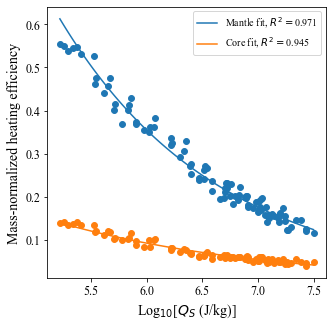

In [24]:
u_core_mantle_bound_mass([accretion20list,accretion30list,accretion45list,accretion60list],labels=None,loglog=True,logfit=True)

### Panel ***b***
Accretion, $\theta=0$

Mantle polynomial coefficients, n...0 :  [-0.24500346  1.08140037]
Mantle R^2 value:  [0.91454562]
Mantle error:  [0.04457369]
Mantle percent error:  [0.09754344] *100
Core polynomial coefficients, n...0 :  [-0.24613151  0.53246584]
Core R^2 value:  [0.96527443]
Core error:  [0.02778487]
Core percent error:  [0.06197346] *100


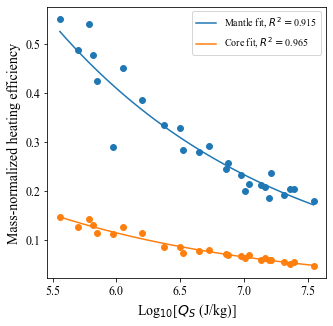

In [25]:
u_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

### Panel ***c***
Accretion, $\theta=75$

Mantle polynomial coefficients, n...0 :  [-0.32851918  1.72897198]
Mantle R^2 value:  [0.97346775]
Mantle error:  [0.03064853]
Mantle percent error:  [0.06813829] *100
Core polynomial coefficients, n...0 :  [-0.23994513  0.56381691]
Core R^2 value:  [0.92985676]
Core error:  [0.03724084]
Core percent error:  [0.08217653] *100


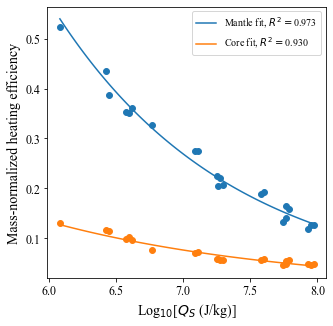

In [26]:
u_core_mantle_bound_mass([accretion75list],labels=None,loglog=True,logfit=True)

### Panel ***d***
Accretion, $\theta=89.7$

Mantle polynomial coefficients, n...0 :  [-0.33542826  2.91515471]
Mantle R^2 value:  [0.97331885]
Mantle error:  [0.02843406]
Mantle percent error:  [0.06337458] *100
Core polynomial coefficients, n...0 :  [-0.22247903  1.17628508]
Core R^2 value:  [0.89804719]
Core error:  [0.03837988]
Core percent error:  [0.08458058] *100


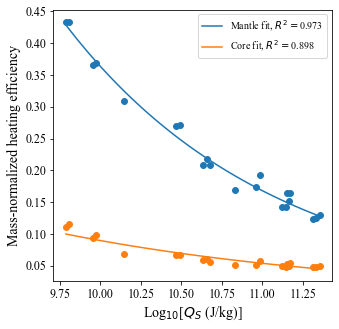

In [27]:
u_core_mantle_bound_mass([accretion897list],labels=None,loglog=True,logfit=True)

## Figure 4

In [110]:
def u_plus_PGPE_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] =1  #(sim.Mplanet[-1]/(sim.M_t+sim.M_i))**(-1)
            IEmantle[j] = (sim.PGPEmantle[-1]+sim.IEmantle[-1])/simlist[j].Etot0
            IEcore[j] = (sim.PGPEcore[-1]+sim.IEcore[-1])/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
    if logfit:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]')#,size=27
        ax.set_ylabel(r'[$(IE+PGPE)/E^0_{tot}$]')#,size=26
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(logspace,10**mantlefitfn(logspace))#label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2
            ax.plot(logspace,10**corefitfn(logspace))#label=r'Core fit in log-log, $r^2=$%.3f'%coreR2
            ax.scatter(logallQS,10**logallmantleIE,s=35,label='Mantle')
            ax.scatter(logallQS,10**logallcoreIE,s=35,label='Core')
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=26
        ax.set_ylabel(r'(Planet IE * Final bound mass $[M_\oplus]$)/($E_{tot}$ * Target mass $[M_\oplus]$)')#,size=26
    if legend: ax.legend(loc='upper left')#bbox_to_anchor=(1.01, 1.0), ,fontsize=22
    if loglog:
        ax.set_yscale('log')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=18
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]')#,size=18
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=18
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major')#, labelsize=24
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def u_plus_PGPE_core_mantle_bound_mass_separate(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(3,1,figsize=(8,12))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    logallcombinedIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        IEcombined=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] =1  #(sim.Mplanet[-1]/(sim.M_t+sim.M_i))**(-1)
            IEmantle[j] = (sim.PGPEmantle[-1]+sim.IEmantle[-1])/simlist[j].Etot0
            IEcore[j] = (sim.PGPEcore[-1]+sim.IEcore[-1])/simlist[j].Etot0
            IEcombined[j] = (sim.PGPEmantle[-1]+sim.IEmantle[-1]+sim.PGPEcore[-1]+sim.IEcore[-1])/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            logallcombinedIE=np.append(logallcombinedIE,np.log10(massplanets[j]*IEcombined[j]))
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
    if logfit:
        ax[2].set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]')#,size=27
        ax[0].set_ylabel(r'[$(IE_{Mantle}+PGPE_{Mantle})/E^0_{tot}$]')#,size=26
        ax[1].set_ylabel(r'[$(IE_{Core}+PGPE_{Core})/E^0_{tot}$]')#,size=26
        ax[2].set_ylabel(r'[$(IE_{Planet}+PGPE_{Planet})/E^0_{tot}$]')#,size=26
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            combinedfit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcombinedIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            combinedR2=1-residuals/np.sum((logallcombinedIE-np.mean(logallcombinedIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            combinedfitfn=np.poly1d(combinedfit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax[0].plot(logspace,10**mantlefitfn(logspace))#label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2
            ax[1].plot(logspace,10**corefitfn(logspace))#label=r'Core fit in log-log, $r^2=$%.3f'%coreR2
            ax[2].plot(logspace,10**combinedfitfn(logspace))#label=r'Full planet fit in log-log, $r^2=$%.3f'%combinedR2
            ax[0].scatter(logallQS,10**logallmantleIE,s=35,label='Mantle',c='k')
            ax[1].scatter(logallQS,10**logallcoreIE,s=35,label='Core',c='k')
            ax[2].scatter(logallQS,10**logallcombinedIE,s=35,label='Full planet',c='k')
    #else:
    #    ax[0].set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=26
    #    ax[0].set_ylabel(r'(Mantle IE * Final bound mass $[M_\oplus]$)/($E_{tot}$ * Target mass $[M_\oplus]$)')#,size=26
    if legend: ax[0].legend(loc='upper left')#bbox_to_anchor=(1.01, 1.0), ,fontsize=22
    if loglog:
        ax[0].set_yscale('log')
        ax[1].set_yscale('log')
        ax[2].set_yscale('log')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=18
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]')#,size=18
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=18
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    ax[2].set_xscale('log')
    if logfit:
        ax[0].set_xscale('linear')
        ax[1].set_xscale('linear')
        ax[2].set_xscale('linear')
        ax[0].set_yscale('linear')
        ax[1].set_yscale('linear')
        ax[2].set_yscale('linear')
    ax[0].tick_params(axis='both', which='major')#, labelsize=24
    ax[1].tick_params(axis='both', which='major')#, labelsize=24
    ax[2].tick_params(axis='both', which='major')#, labelsize=24
    ax[0].set_title('Mantle')
    ax[1].set_title('Core')
    ax[2].set_title('Full planet')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

Mantle polynomial coefficients, n...0 :  [-0.05069879  0.17515102]
Mantle R^2 value:  [0.57004685]
Core polynomial coefficients, n...0 :  [-0.04646314 -0.488923  ]
Core R^2 value:  [0.42148135]


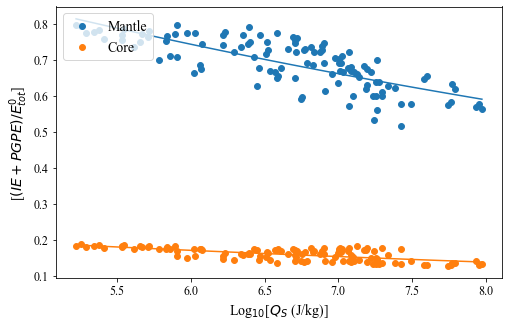

In [111]:
u_plus_PGPE_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)

Mantle polynomial coefficients, n...0 :  [-0.05069879  0.17515102]
Mantle R^2 value:  [0.57004685]
Core polynomial coefficients, n...0 :  [-0.04646314 -0.488923  ]
Core R^2 value:  [0.42148135]
Mantle polynomial coefficients, n...0 :  [-0.05069879  0.17515102]
Mantle R^2 value:  [0.57004685]


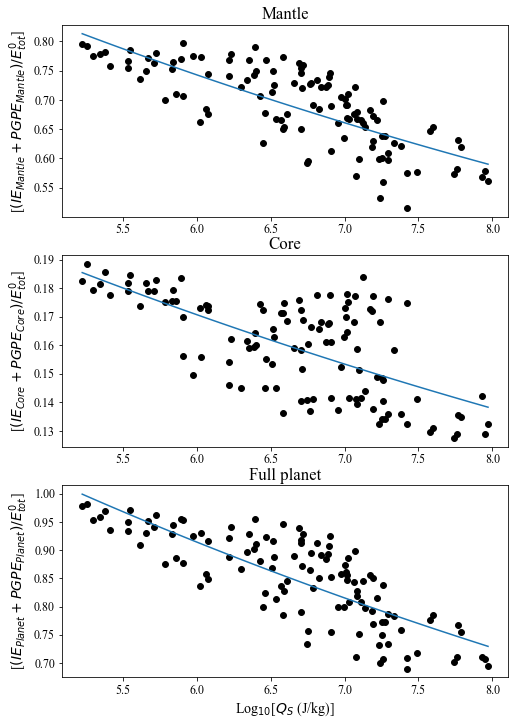

In [112]:
u_plus_PGPE_core_mantle_bound_mass_separate([accretionlistno0],labels=None,loglog=True,logfit=True,legend=False)

## Figure 5

In [30]:
def QS_u_core_mantle_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/sim.IEplanet[-1]
            IEcore[j] = sim.IEcore[-1]/sim.IEplanet[-1]
            logallmantleIE=np.append(logallmantleIE,IEmantle[j])
            logallcoreIE=np.append(logallcoreIE,IEcore[j])
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Mantle polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
        ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
        ax.set_xlabel('Log[QS (J/kg)]')
        ax.set_ylabel('Log[Planet internal energy/Total initial energy]')
    else:
        ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',)
        ax.set_ylabel('Fraction of largest remnant internal energy')
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
    if legend: ax.legend(loc='upper right')#bbox_to_anchor=(1.01, 1.0), 
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()


### Panel **a**
Accretion, no head on or 89.7$^o$

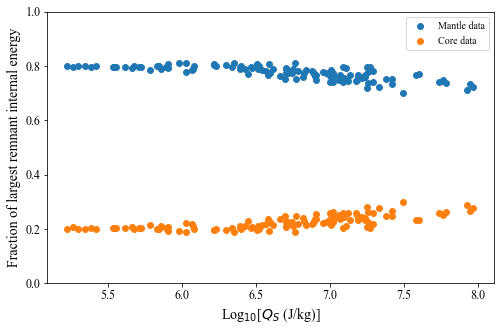

In [31]:
QS_u_core_mantle_fraction([accretionlistno0],labels=None)

### Panel **b**
Hit-and-run

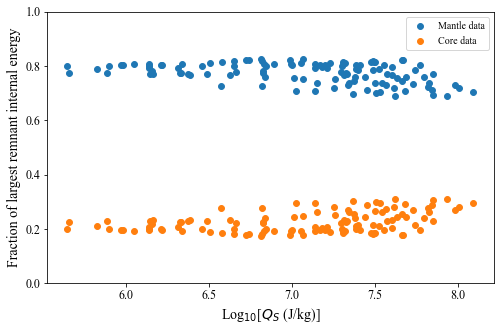

In [32]:
QS_u_core_mantle_fraction([hitandrunlist],labels=None)

## Figure 6

In [33]:
def dPT_CMB(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allmass=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mbound[-1]
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
    if colors=='mass':
        pltnorm=Normalize(vmin=np.amin(allmass),vmax=np.amax(allmass))
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if colors=='mass':c=sim.Mbound[-1]
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='cividis',norm=pltnorm)
                else:
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DTplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='cividis'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
        if colors=='mass':cbar.set_label(r'Mass [$M_\oplus$]',size=22)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent T deviation from initial CMB',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from initial CMB',size=24)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=18)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()


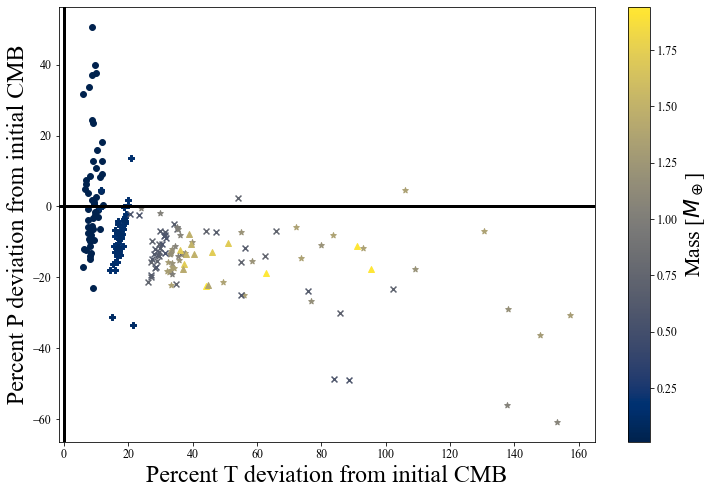

In [34]:
dPT_CMB([accretionlist,partialaccretionlist],labels=None,colors='mass',legend=False,markers='size')

## Figure 7 \& Supplementary Figure 20

In [35]:
def logTlogfnfull(x,a2,a1,a0,b2,b1,b0,c2,c1,c0):
    return np.log10(Tlogfnfull(x,a2,a1,a0,b2,b1,b0,c2,c1,c0))

def corelogTlogfnfull(x,a3,a2,a1,a0,b3,b2,b1,b0):
    return np.log10(coreTlogfnfull(x,a3,a2,a1,a0,b3,b2,b1,b0))

def fit_deltaT_CMB(simlistlist,normalize=False,core=False):
    allDTs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QSs[j] = sim.QS
            allQSs=np.append(allQSs,QSs[j])
            thetas[j] = sim.theta
            allthetas=np.append(allthetas,thetas[j])
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                #DTplanets[j] = np.amax(sim.Tmeancore)-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            allDTs=np.append(allDTs,DTplanets[j])
    allx=np.stack((np.log10(allQSs),allthetas),axis=-1)
    print(np.shape(allx))
    print(np.shape(allDTs))
    if core:
        p0= [-4.09329849e-06,4.72920684e-04,-1.10967093e-02,8.89456821e-01,
             2.32015049e-05,-3.12788333e-03,8.44398990e-02,-2.10083428e+00]
    else:
        p0=[1.56468107e-05,-6.63974519e-03,3.89728327e-01,
        -3.39416858e-04,8.98433801e-02,-4.29938899e+00,
        1.39887809e-03,-2.95388474e-01,1.42879395e+01,]
    #print(quadlogfnfull(allx[0],*p0))
    if core:
        params,extras=curve_fit(corelogTlogfnfull,allx,np.log10(allDTs),p0)
        #params,extras=curve_fit(coreTlogfnfull,allx,(allDTs),p0)
        R2=1-np.sum((np.log10(allDTs)-np.log10(coreTlogfnfull(allx,*params)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
        #R2=1-np.sum(((allDTs)-(coreTlogfnfull(allx,*params)))**2)/np.sum(((allDTs)-np.mean((allDTs)))**2)
    else:
        params,extras=curve_fit(logTlogfnfull,allx,np.log10(allDTs),p0)
        #params,extras=curve_fit(Tlogfnfull,allx,(allDTs),p0)
        R2=1-np.sum((np.log10(allDTs)-np.log10(Tlogfnfull(allx,*params)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
        #R2=1-np.sum(((allDTs)-(Tlogfnfull(allx,*params)))**2)/np.sum(((allDTs)-np.mean((allDTs)))**2)
    print('R^2: ',R2)
    
    return params
            
#deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None):
Tquadfit=fit_deltaT_CMB([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],normalize=True)    
print(Tquadfit)
coreTquadfit=fit_deltaT_CMB([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],normalize=True,core=True)    
print(coreTquadfit)

(119, 2)
(119,)
R^2:  0.934039632512224
[ 3.55907399e-05 -6.73212443e-03  3.64851071e-01 -5.99854823e-04
  9.07061776e-02 -3.97120631e+00  2.24104151e-03 -2.96804734e-01
  1.32120871e+01]
(119, 2)
(119,)
R^2:  0.9073348093521388
[-2.66949609e-06  3.64859195e-04 -9.95973149e-03  9.06618417e-01
  1.41359773e-05 -2.45226560e-03  7.80689720e-02 -2.21953260e+00]


In [36]:
def deltaT_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None,fullparams=None,core=False,residuals=False,savefig=None):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(18,10))#
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield0=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield0=np.arange(0,90,1)
    thetafield,QSfield = np.meshgrid(thetafield0,QSfield0)
    logthetafield,logQSfield = np.meshgrid(thetafield0,np.log10(QSfield0))
    if fitlist is not None:
        #Z=10.**(vlogdeltaT3D(QSfield,thetafield,fitlist))
        Z=(vlogdeltaT3D(QSfield,thetafield,fitlist))
        #print(Z)
    if fullparams is not None:
        #Z=vTlogfnfull(logQSfield,logthetafield,*fullparams)
        if core: Z=np.log10(vcoreTlogfnfull(logQSfield,logthetafield,*fullparams))
        else: Z=np.log10(vTlogfnfull(logQSfield,logthetafield,*fullparams))
        #print(Z)
    
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    allDTs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if core:
                r = sim.RRRmant[0]
                rcore = np.where(sim.RRRcore<r)
                DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
            else:
                DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allDTs=np.append(allDTs,DTplanets[j])
            allthetas=np.append(allthetas,thetas[j])
            allQSs=np.append(allQSs,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    one=True
                    two=True
                    if (fitlist is not None):
                        if core: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        else: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        if (overT<DTplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if core: overT=(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        else: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        if overT<DTplanets[j]:
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                        #ax.scatter(np.log10(QSs[j]),thetas[j],vquadparams(QSs[j],thetas[j],fitlist),s=35,color='blue')
                else:
                    one=True
                    two=True
                    if (fitlist is not None):
                        if core: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        else: overT=(10.**(logdeltaT3D(QSs[j],thetas[j],fitlist)))
                        if (overT<DTplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if core: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        else: overT=(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))
                        if overT<DTplanets[j]:
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(thetas,np.log10(QSs),np.log10(DTplanets),label=labels[i],s=35,marker=marker)
    if fitlist is not None:
        if core:
            R2=1-np.sum((allDTs-10.**(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            logR2=1-np.sum((np.log10(allDTs)-(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
        else:
            R2=1-np.sum((allDTs-10.**(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            logR2=1-np.sum((np.log10(allDTs)-(vlogdeltaT3D(allQSs,allthetas,fitlist)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
    if fullparams is not None:
        if core:
            R2=1-np.sum((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            err=np.sqrt(np.sum((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error: ',err,' K')
            percenterr=np.sqrt(np.sum(((allDTs-(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))/vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams))**2)/np.size(allDTs))*100
            print('Percent standard error: ',percenterr)
            logR2=1-np.sum((np.log10(allDTs)-np.log10(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
            err=np.sqrt(np.sum((np.log10(allDTs)-np.log10(vcoreTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error in log-log fit: ',10**err,' K')
            print('Error in log-log fit in logK: ',err,' K')
        else:
            R2=1-np.sum((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((allDTs-np.mean(allDTs))**2)
            print('R^2: ',R2)
            err=np.sqrt(np.sum((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error: ',err,' K')
            percenterr=np.sqrt(np.sum(((allDTs-(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))/vTlogfnfull(np.log10(allQSs),allthetas,*fullparams))**2)/np.size(allDTs))*100
            print('Percent standard error: ',percenterr)
            logR2=1-np.sum((np.log10(allDTs)-np.log10(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.sum((np.log10(allDTs)-np.mean(np.log10(allDTs)))**2)
            print('log R^2: ',logR2)
            err=np.sqrt(np.sum((np.log10(allDTs)-np.log10(vTlogfnfull(np.log10(allQSs),allthetas,*fullparams)))**2)/np.size(allDTs))
            print('Error in log-log fit: ',10**err,' K')
            print('Error in log-log fit in logK: ',err,' K')
    ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    #ax.plot_surface(logQSfield,logthetafield,  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if core:
            r = sim.RRRmant[0]
            rcore = np.where(sim.RRRcore<r)
            DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
            #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
        else:
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
        if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                #ax.scatter(np.log10(QSs[j]),thetas[j],vquadparams(QSs[j],thetas[j],fitlist),s=35,color='blue')
            else:
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=18)
    ax.set_ylabel('Impact angle (degrees)',size=18)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'Log$_{10}[\Delta K$]',size=18)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
    if residuals:
        fig1,ax1=plt.subplots(1,1,figsize=(16,8))
        for i in range(np.shape(simlistlist)[0]):
            simlist = simlistlist[i]
            Lzs=np.zeros(np.size(simlist))
            QSs=np.zeros(np.size(simlist))
            thetas=np.zeros(np.size(simlist))
            DTplanets=np.zeros(np.size(simlist))
            resids=np.zeros(np.size(simlist))
            for j in range(np.size(simlist)):
                #print(i,j)
                sim=simlist[j]
                marker=sim.thetamarker
                if core:
                    r = sim.RRRmant[0]
                    rcore = np.where(sim.RRRcore<r)
                    DTplanets[j] = sim.Tmeancore[rcore][-1]-sim.TCMB0core
                    #DTplanets[j]=np.amax(sim.Tmeancore)-sim.TCMB0core
                else:
                    DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
                
                if normalize: DTplanets[j] = DTplanets[j]/(sim.M_t/sim.Mbound[-1])
                thetas[j] = sim.theta
                QSs[j] = sim.QS
                if (fitlist is not None):
                    resids[j]=np.log10(DTplanets[j])-logdeltaT3D(QSs[j],thetas[j],fitlist)
                if (fullparams is not None):
                    if core: resids[j]=(np.log10(DTplanets[j])-np.log10(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)))/np.log10(coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))*100
                    #if core: resids[j]=(DTplanets[j]-coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))/coreTlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)*100
                    else: resids[j]=(np.log10(DTplanets[j])-np.log10(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams)))/np.log10(Tlogfnfull2(np.log10(QSs[j]),thetas[j],*fullparams))*100
                
            ax1.scatter(np.log10(QSs),resids,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
            #ax1.scatter(np.log10(QSs),DTplanets,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
        ax1.hlines(0,np.amin(np.log10(allQSs))-0.5,np.amax(np.log10(allQSs))+0.5,color='black')
        ax1.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=24)
        ax1.set_xlim(np.amin(np.log10(allQSs))-0.1,np.amax(np.log10(allQSs))+0.1)
        ax1.set_ylabel(r'Log$_{10}$($\Delta T$) Percent Residuals',size=24)
        ax1.legend(fontsize=20)
        plt.tight_layout()
        if savefig is not None:
            imname=savefig+'_residuals.pdf'
            plt.savefig(imname)
    plt.show()

### Panel **a**: Core side

R^2:  0.6987445580690685
Error:  4890.183663789032  K
Percent standard error:  50.27464034205966
log R^2:  0.906823158032121
Error in log-log fit:  1.5259276117058145  K
Error in log-log fit in logK:  0.1835339316644742  K


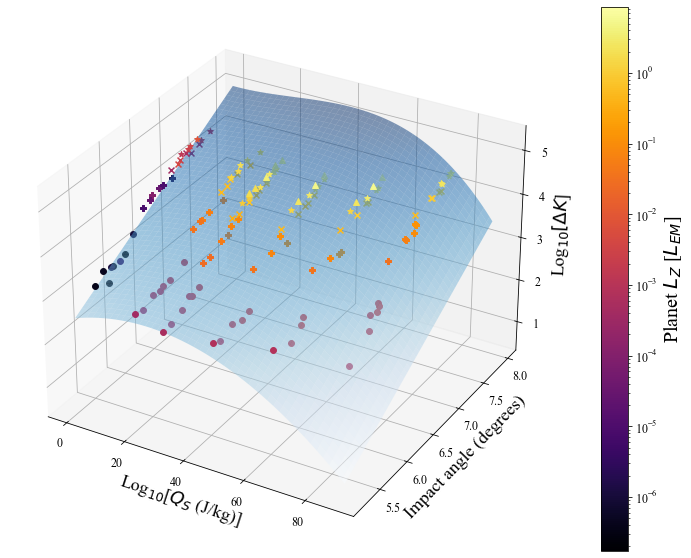

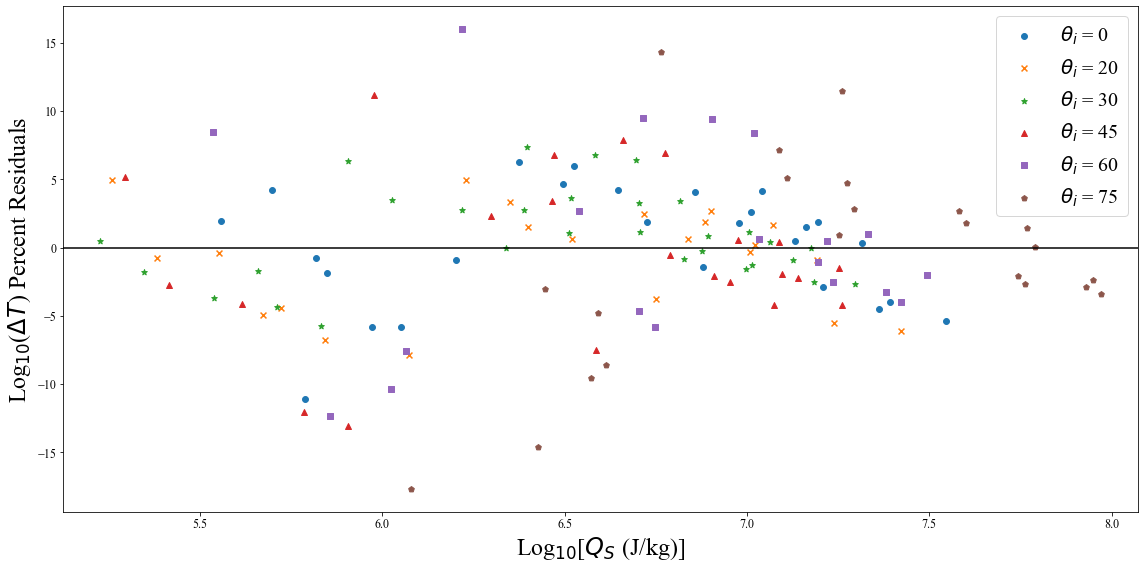

In [37]:
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,core=True,fullparams=coreTquadfit,residuals=True,savefig='deltaT_core0-75')

### Panel **b**: Mantle side

R^2:  0.8768000161591385
Error:  496.8401850934127  K
Percent standard error:  25.3209242394369
log R^2:  0.9268569286460595
Error in log-log fit:  1.2910235687731633  K
Error in log-log fit in logK:  0.11093417076734811  K


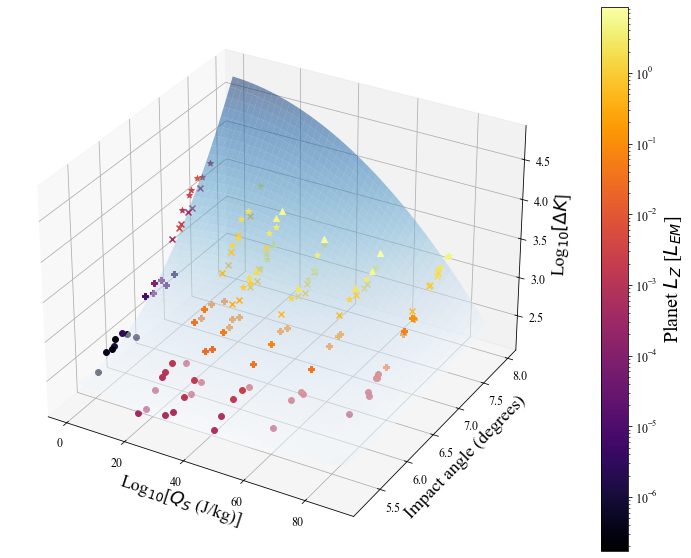

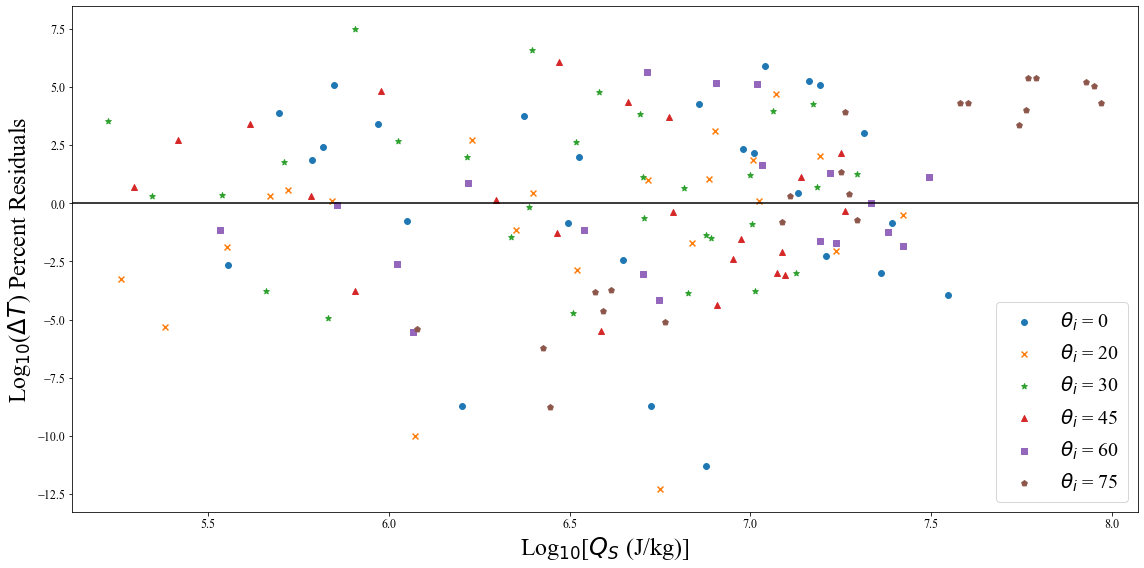

In [38]:
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',normalize=True,fullparams=Tquadfit,residuals=True,savefig='deltaT_mantle0-75')

## Figure 8 \& Supplementary Figure 21

In [39]:
def fit_deltaP_CMB(simlistlist,normalize=False):
    allDPs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QSs[j] = sim.QS
            allQSs=np.append(allQSs,QSs[j])
            thetas[j] = sim.theta
            allthetas=np.append(allthetas,thetas[j])
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            allDPs=np.append(allDPs,DPplanets[j])
    allx=np.stack((np.log10(allQSs),allthetas),axis=-1)
    print(np.shape(allx))
    print(np.shape(allDPs))
    p0=[-1.51035560e-03,9.17692805e-02,-1.25309311e+00,
        2.31485491e-02,-1.41791544e+00,2.02773354e+01,
        -8.87976100e-02,5.48025197e+00,-8.00556575e+01,
        -4.16995470e-03,2.52604924e-01,-2.92760730e+00]
    #print(quadlogfnfull(allx[0],*p0))
    params,extras=curve_fit(quadlogfnfull,allx,allDPs,p0)
    R2=1-np.sum((allDPs-quadlogfnfull(allx,*params))**2)/np.sum((allDPs-np.mean(allDPs))**2)
    print('R^2: ',R2)
    err=np.sqrt(np.sum((allDPs-quadlogfnfull(allx,*params))**2)/np.size(allDPs))
    print('Error: ',err,' GPa')
    idxsmall = np.where(np.abs(allDPs)<err)
    errsmall=np.sqrt(np.sum((allDPs[idxsmall]-quadlogfnfull(allx[idxsmall],*params))**2)/np.size(allDPs[idxsmall]))
    print('Small-value Error: ',errsmall,' GPa')
    idxbig = np.where(np.abs(allDPs)>err)
    errbig=np.sqrt(np.sum((allDPs[idxbig]-quadlogfnfull(allx[idxbig],*params))**2)/np.size(allDPs[idxbig]))
    print('Large-value Error: ',errbig,' GPa')
    
    return params
            
#deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None):
betterquadfit=fit_deltaP_CMB([accretion010list+partialaccretion010list,accretion20list+partialaccretion20list,accretion30list+partialaccretion30list,accretion45list,accretion60list,accretion75list])    
print(betterquadfit)

(169, 2)
(169,)
R^2:  0.865659324016002
Error:  4.469182955058008  GPa
Small-value Error:  1.9616873753727517  GPa
Large-value Error:  6.024196544736586  GPa
[-6.14401904e-04  2.99993491e-02 -8.11063881e-02  9.47458388e-03
 -4.73584751e-01  2.57852108e+00 -3.68500118e-02  1.88444458e+00
 -1.32787966e+01 -2.33965573e-03  1.25206221e-01 -6.23724837e-01]


In [40]:
def deltaP_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=None,fullparams=None,residuals=False,savefig=None):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(18,10))#
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield0=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield0=np.arange(0,90,1)
    QSfield,thetafield = np.meshgrid(QSfield0,thetafield0)
    #thetafield,QSfield = np.meshgrid(thetafield0,QSfield0)
    logQSfield,logthetafield=np.meshgrid(np.log10(QSfield0),thetafield0)
    #logthetafield,logQSfield=np.meshgrid(thetafield0,np.log10(QSfield0))
    if fitlist is not None:
        Z=vquadparams(QSfield,thetafield,fitlist)
        #Z=vquadparams(thetafield,QSfield,fitlist)
    if fullparams is not None:
        Z=vquadlogfnfull(logQSfield,logthetafield,*fullparams)
        #Z=vquadlogfnfull(logthetafield,logQSfield,*fullparams)
        #print(Z)
    
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    allDPs=np.array([])
    allthetas=np.array([])
    allQSs=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
            else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allDPs=np.append(allDPs,DPplanets[j])
            allthetas=np.append(allthetas,thetas[j])
            allQSs=np.append(allQSs,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    one=True
                    two=True
                    if (fitlist is not None):
                        if (vquadparams(QSs[j],thetas[j],fitlist)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(np.log10(QSs[j]),thetas[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                        #ax.scatter(thetas[j],np.log10(QSs[j]),DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    one=True
                    two=True
                    if (fitlist is not None): 
                        if (vquadparams(QSs[j],thetas[j],fitlist)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            one=False
                    if (fullparams is not None):
                        if (quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)<DPplanets[j]):
                            overlist=np.append(overlist,sim)
                            two=False
                    if one&two:
                        ax.scatter(np.log10(QSs[j]),thetas[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                        #ax.scatter(thetas[j],np.log10(QSs[j]),DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(np.log10(QSs),thetas,DPplanets,label=labels[i],s=35,marker=marker)
            #ax.scatter(thetas,np.log10(QSs),DPplanets,label=labels[i],s=35,marker=marker)
    if fitlist is not None:
        R2=1-np.sum((allDPs-vquadparams(allQSs,allthetas,fitlist))**2)/np.sum((allDPs-np.mean(allDPs))**2)
        print('R^2: ',R2)
    ax.plot_surface(np.log10(QSfield),thetafield,  Z,alpha=0.5,cmap='Blues')
    #ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
        else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(np.log10(QSs[j]),thetas[j],(DPplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                #ax.scatter(thetas[j],np.log10(QSs[j]),(DPplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(np.log10(QSs[j]),thetas[j],(DPplanets[j]),label=sim.label,s=35,marker=marker)
                #ax.scatter(thetas[j],np.log10(QSs[j]),(DPplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label(r'Planet L$_Z$ [$L_{EM}$]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=18)
    ax.set_ylabel('Impact angle (degrees)',size=18)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'$\Delta$P (GPa)',size=20)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname)
    plt.show()
    
    if residuals:
        fig1,ax1=plt.subplots(1,1,figsize=(16,8))
        for i in range(np.shape(simlistlist)[0]):
            simlist = simlistlist[i]
            Lzs=np.zeros(np.size(simlist))
            QSs=np.zeros(np.size(simlist))
            thetas=np.zeros(np.size(simlist))
            DPplanets=np.zeros(np.size(simlist))
            resids=np.zeros(np.size(simlist))
            for j in range(np.size(simlist)):
                #print(i,j)
                sim=simlist[j]
                marker=sim.thetamarker
                if normalize: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/(sim.M_t/sim.Mbound[-1])/1.e9 #/sim.PCMB0*100
                else: DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/1.e9 #/sim.PCMB0*100
                thetas[j] = sim.theta
                QSs[j] = sim.QS
                if (fitlist is not None):
                    resids[j]=((DPplanets[j])-(vquadparams(QSs[j],thetas[j],fitlist)))#/(vquadparams(QSs[j],thetas[j],fitlist)+35)*100
                if (fullparams is not None):
                    resids[j]=((DPplanets[j])-(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)))#/(quadlogfnfull([np.log10(QSs[j]),thetas[j]],*fullparams)+35)*100
                
            ax1.scatter(np.log10(QSs),resids,s=35,marker=marker,label=r'$\theta_i$ = %g'%sim.theta)
        ax1.hlines(0,np.amin(np.log10(allQSs))-0.5,np.amax(np.log10(allQSs))+0.5,color='black')
        ax1.set_xlabel(r'Log$_{10}$[$Q_S$ (J/kg)]',size=24)
        ax1.set_xlim(np.amin(np.log10(allQSs))-0.1,np.amax(np.log10(allQSs))+0.1)
        ax1.set_ylabel(r'$\Delta P$ [GPa] Residuals',size=24)
        ax1.legend(fontsize=20)
        plt.tight_layout()
        if savefig is not None:
            imname=savefig+'_residuals.pdf'
            plt.savefig(imname)
    plt.show()

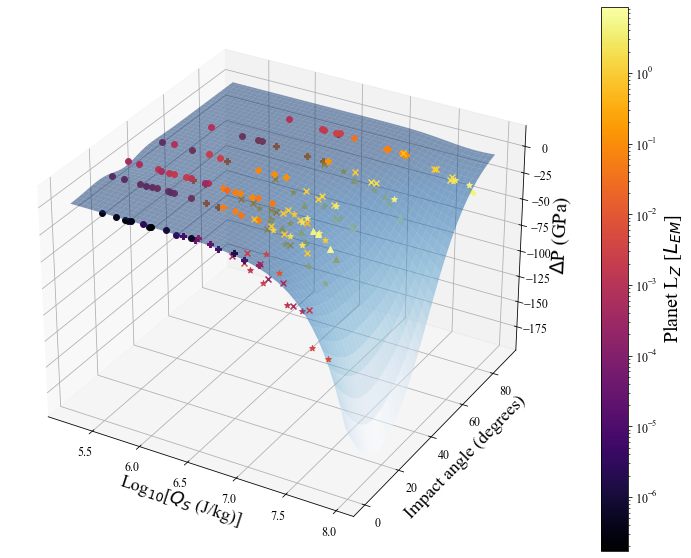

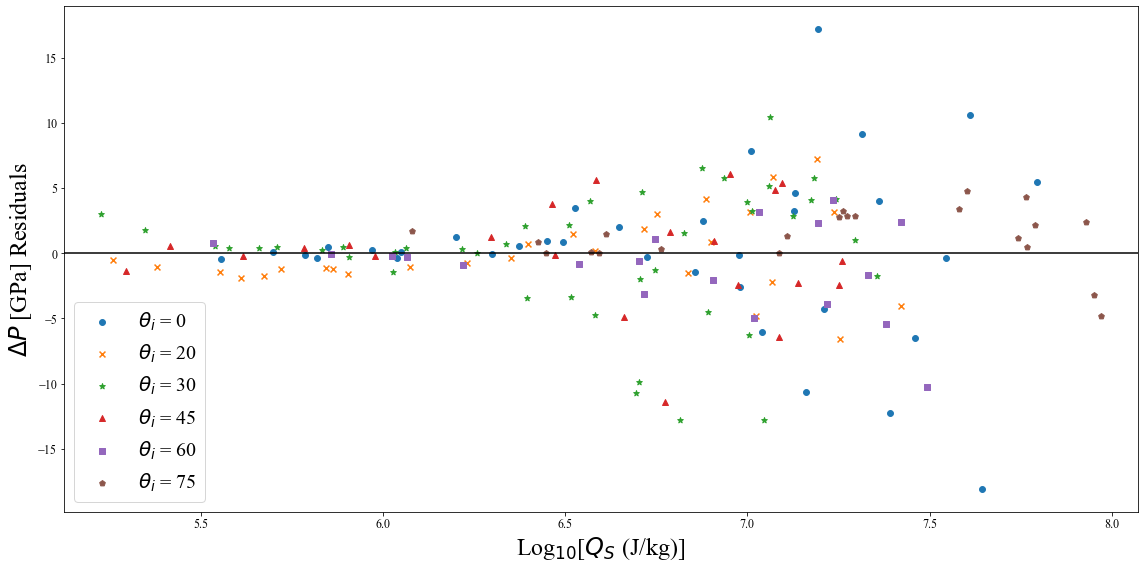

In [41]:
%matplotlib inline
deltaP_CMB_QS3D([accretion010list+partialaccretion010list,accretion20list+partialaccretion20list,accretion30list+partialaccretion30list,accretion45list,accretion60list,accretion75list],labels=None,colors='Lz',legend=False,markers='size',fullparams=betterquadfit,residuals=True,savefig='deltaP_0-75')

## Figure 9

In [80]:
def mantle_phase_bar_combined(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=False,title=None,savefig=None):
    infernomap = plt.cm.get_cmap('inferno',8)
    norm=colors.Normalize(vmin=1,vmax=8,clip=True)
    allsims=np.array([])
    QSs=np.array([])
    QS0=np.array([])
    QS20=np.array([])
    QS30=np.array([])
    QS45=np.array([])
    QS60=np.array([])
    QS75=np.array([])
    QS897=np.array([])
    sim0=np.array([])
    sim20=np.array([])
    sim30=np.array([])
    sim45=np.array([])
    sim60=np.array([])
    sim75=np.array([])
    sim897=np.array([])
    thetabool=np.zeros(7)
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if hasattr(sim, 'NmantPhaseFrac'):
                allsims=np.append(allsims,sim)
            if star:
                QSs=np.append(QSs,sim.QstarS)
            else:
                QSs=np.append(QSs,sim.QS)
            if sim.theta<10: 
                QS0=np.append(QS0,QSs[-1])
                sim0=np.append(sim0,sim)
                thetabool[0]=1
            if sim.theta==20: 
                QS20=np.append(QS20,QSs[-1])
                sim20=np.append(sim20,sim)
                thetabool[1]=1
            if sim.theta==30: 
                QS30=np.append(QS30,QSs[-1])
                sim30=np.append(sim30,sim)
                thetabool[2]=1
            if sim.theta==45: 
                QS45=np.append(QS45,QSs[-1])
                sim45=np.append(sim45,sim)
                thetabool[3]=1
            if sim.theta==60: 
                QS60=np.append(QS60,QSs[-1])
                sim60=np.append(sim60,sim)
                thetabool[4]=1
            if sim.theta==75: 
                QS75=np.append(QS75,QSs[-1])
                sim75=np.append(sim75,sim)
                thetabool[5]=1
            if sim.theta>89: 
                QS897=np.append(QS897,QSs[-1])
                sim897=np.append(sim897,sim)
                thetabool[6]=1
    
    #phase=np.zeros(np.size(QSs))
    phases=np.zeros((8,np.size(QSs)))
    phase0=np.zeros((8,np.size(QS0)))
    phase20=np.zeros((8,np.size(QS20)))
    phase30=np.zeros((8,np.size(QS30)))
    phase45=np.zeros((8,np.size(QS45)))
    phase60=np.zeros((8,np.size(QS60)))
    phase75=np.zeros((8,np.size(QS75)))
    phase897=np.zeros((8,np.size(QS897)))
    thetastrings=['Head-on',r'$\theta$=20$^{\circ}$',r'$\theta$=30$^{\circ}$',r'$\theta$=45$^{\circ}$',r'$\theta$=60$^{\circ}$',
                 r'$\theta$=75$^{\circ}$',r'$\theta$=90$^{\circ}$']
    QSlist=[QS0,QS20,QS30,QS45,QS60,QS75,QS897]
    simslist=[sim0,sim20,sim30,sim45,sim60,sim75,sim897]
    phaselist=[phase0,phase20,phase30,phase45,phase60,phase75,phase897]
    
    fig,ax=plt.subplots(np.sum(thetabool,dtype='int'),1,figsize=(11,21))
    jj=-1
    for j in range(7):
        if thetabool[j]==1:
            jj+=1
            QSsort=np.argsort(QSlist[j])
            width=np.zeros(np.size(QSsort))
            for i in range(np.size(QSlist[j])):
                sim=simslist[j][QSsort][i]
                for k in range(8):
                    phaselist[j][k][i]=sim.NmantPhaseFrac[k+1]
                if i<(np.size(QSsort)-1):
                    width[i]=QSlist[j][QSsort][i+1]-QSlist[j][QSsort][i]
                else:
                    width[i]=QSlist[j][QSsort][i]-QSlist[j][QSsort][i-1]
            bottom=np.zeros(np.size(QSsort))
            for k in range(8):
                ax[jj].bar(QSlist[j][QSsort],phaselist[j][k,:],width=width,bottom=bottom,align='edge',
                                   color=infernomap(k/7),edgecolor='black')
                bottom+=phaselist[j][k]
            ax[jj].set_xscale('log')
            ax[jj].set_xlim(QSlist[j][QSsort][0],QSlist[j][QSsort][-1]+width[-1])
            ax[jj].tick_params(axis='both', which='major', labelsize=18)
            ax[jj].tick_params(axis='both', which='minor', labelsize=16)
            ax[jj].set_yticks((0.0,0.5,1.0))
            ax[jj].set_title(thetastrings[j],size=20)
    phasestrings=['Solid ','Solid + vapor ','Melt ','Liquid ','Liquid + vapor ','Vapor ','Gas ','Supercritical ']
    plt.gca().set_xlabel(r'$Q_S$ [J/kg]',size=24)
    #fig.subplots_adjust(right=0.8)
    fig.supylabel('Mantle phase fraction',size=26)
    if title is not None:
        fig.suptitle(title+'\n',size=28)
    plt.tight_layout()
    cbar_ax = fig.add_axes([1., .05, 0.05, .93])
    cmant=plt.colorbar(cm.ScalarMappable(norm=norm, cmap=infernomap),cax=cbar_ax)
    cmant.set_label('Phase',size=28)
    cmant.ax.set_yticklabels(phasestrings,fontsize=20)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    #plt.gcf().set_size_inches(18,12)
    plt.show()


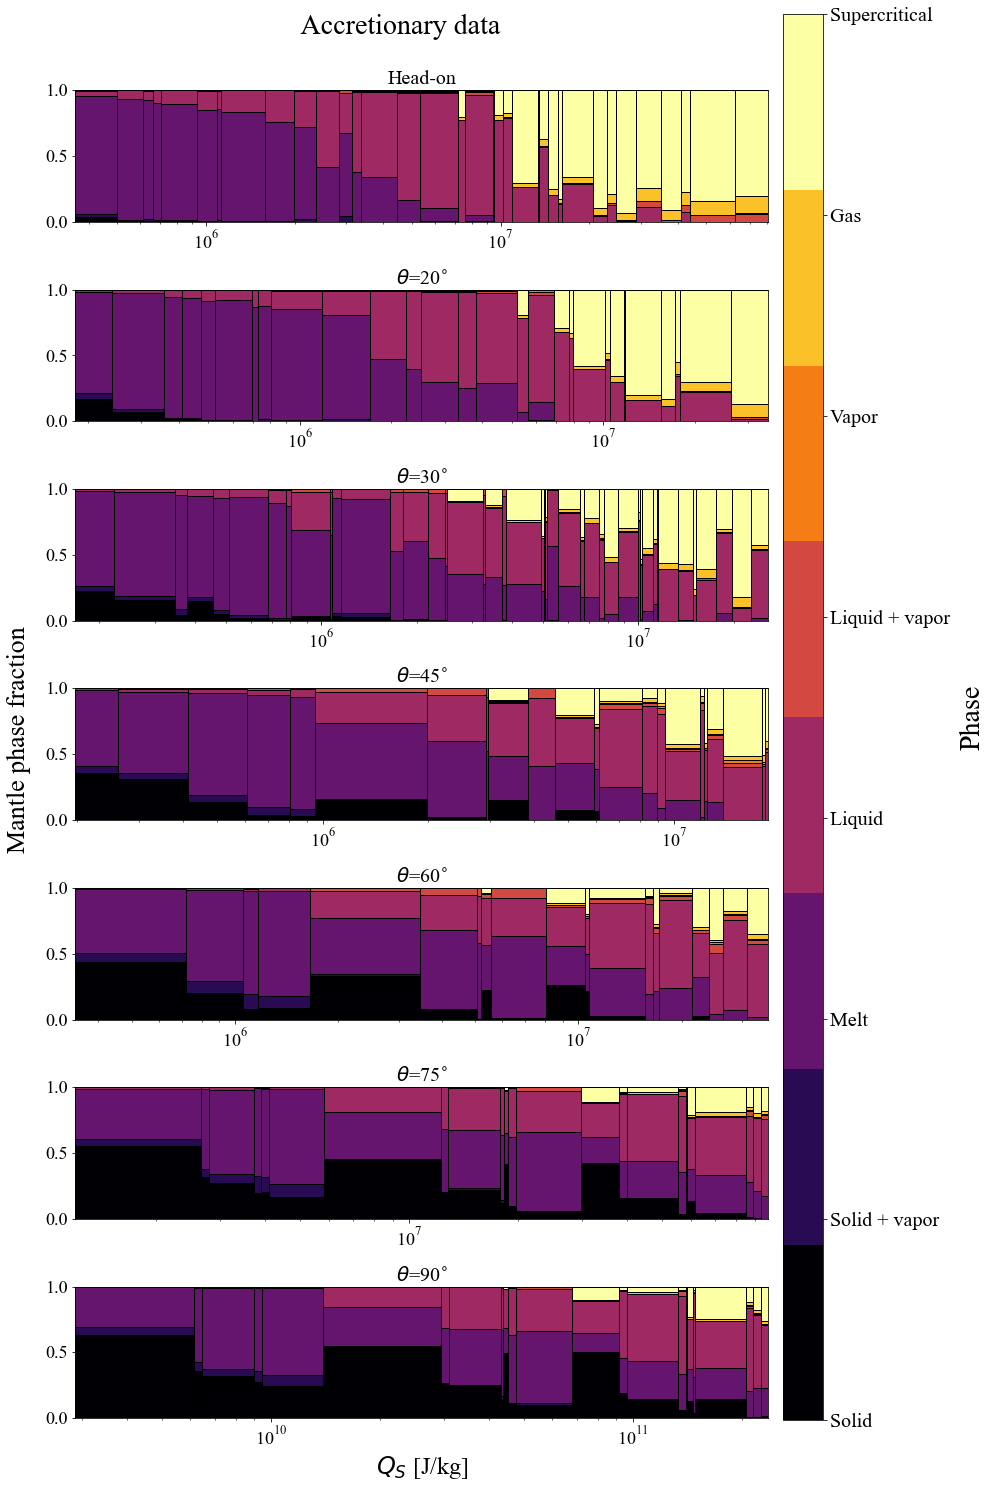

In [81]:
mantle_phase_bar_combined([accretionlist,partialaccretionlist],markers='size',labels=None,title='    Accretionary data')

## Figure 10

In [87]:
def mant_misc_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        fracplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            fracplanets[j] = sim.miscmantfrac
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            #DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,fracplanets,label=labels[i],s=65,marker=marker)
               
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=22
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]')#,size=22
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=22
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=24
    ax.set_ylabel('Mantle fraction above Fe-MgO solvus')#,size=24
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')#,fontsize=14
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def core_misc_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        fracplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            fracplanets[j] = sim.misccorefrac
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            #DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=65,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,fracplanets,label=labels[i],s=65,marker=marker)
               
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=22
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]')#,size=22
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=22
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=24
    ax.set_ylabel('Core fraction above Fe-MgO solvus')#,size=24
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')#,fontsize=14
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()


### Panel **a**: Core

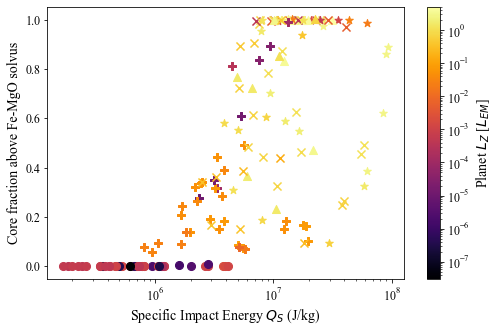

In [88]:
core_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=False,colors='Lz',legend=False,markers='size')

### Panel b: Mantle

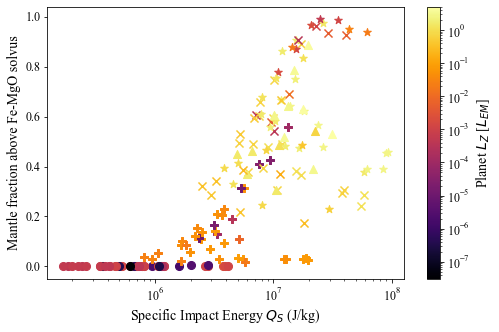

In [89]:
mant_misc_QS([accretionlistno90,partialaccretionlistno90],labels=None,loglog=False,colors='Lz',legend=False,markers='size')

## Figures 12 & 11
Loading run-specific analysis code, then using run name halfearth0.5x0.25v1.15th30 as the example depicted in the figures.

In [47]:
from IE_gain_read import *
basename="./survey data/mass1to2/halfearth/halfearth0.5x0.25th30/halfearth0.5x0.25v1.15th30"
Nsnap=288
snapshot0=basename+'_%04d.hdf5' % 0
data0 = sw.load(snapshot0)
data0.create_particle_datasets()
data0.gas.coordinates.convert_to_mks()
data0.gas.pressures.convert_to_mks()
data0.gas.internal_energies.convert_to_mks()
data0.gas.masses.convert_to_mks()
data0.gas.velocities.convert_to_mks()
data0.gas.smoothing_lengths.convert_to_mks()
data0.gas.densities.convert_to_mks()
data0.gas.potentials.convert_to_mks()

Ntot = data0.gas.metadata.n_gas

cm,vcm = find_initial_com(data0)
print('Initial CoM/vCoM: ',cm,vcm)

snapshot = basename+'_%04d.hdf5' % Nsnap

data = sw.load(snapshot)
data.create_particle_datasets()
data.gas.coordinates.convert_to_mks()
data.gas.pressures.convert_to_mks()
data.gas.internal_energies.convert_to_mks()
data.gas.masses.convert_to_mks()
data.gas.velocities.convert_to_mks()
data.gas.smoothing_lengths.convert_to_mks()
data.gas.densities.convert_to_mks()
data.gas.potentials.convert_to_mks()    
snaptime = data.metadata.time.in_mks()

indbnd, Mbound,pos,vel = bound_mass(data, cm, vcm)
Nbound = np.shape(indbnd)[1]
databnd = apply_index(data, indbnd)
bcm,bvcm = find_initial_com(databnd)
inddisk, indplanet, diskm, planetm, rplanet = find_disk(databnd, bcm, bvcm, pos[indbnd], vel[indbnd],basename=basename)
#trying again for double-checking in accretionary cases
inddisk2, indplanet2, diskm2, planetm2, rplanet2 = find_disk(databnd, bcm, bvcm, pos[indbnd], vel[indbnd],basename=basename,rplanetmax=rplanet*R_earth)
if (planetm/(planetm+diskm)-planetm2/(planetm2+diskm2))<0.025:
    inddisk, indplanet, diskm, planetm, rplanet = inddisk2, indplanet2, diskm2, planetm2, rplanet2
    print('Planet/disk boundary: r = ',rplanet,'R_earth')
    print('Planet mass: ',planetm,' fraction of bound mass: ',planetm/(planetm+diskm))
    print('Disk mass: ',diskm,' fraction of bound mass: ',diskm/(planetm+diskm))

print('Bound mass CoM/vCoM: ',bcm,bvcm)

C:\Users\gerri\miniforge3\lib\site-packages\woma\__init__.py
Could not find gas gamma, assuming 5./3.
Initial CoM/vCoM:  [24340.75943723722, 20389.97970446211, 19982.164115191124] [-0.80410886, 0.1123897, -5.161977e-05]
Could not find gas gamma, assuming 5./3.
center:  -0.014737329884331437 -0.002774071802608119 0.08484707446060445
0
Nbound:  123755
-78854670.0
bound mass:  0.022508686293861643  | new mass:  0.44524909050893047  | diff:  0.4227404042150688
center:  -0.014737329884331437 -0.002774071802608119 0.08484707446060445
1
Nbound:  205075
-78854670.0
bound mass:  0.44524909050893047  | new mass:  0.7384619179807612  | diff:  0.29321282747183075
center:  -0.014737329884331437 -0.002774071802608119 0.08484707446060445
2
Nbound:  205882
-78854670.0
bound mass:  0.7384619179807612  | new mass:  0.7413826852761664  | diff:  0.0029207672954051547
center:  -0.014737329884331437 -0.002774071802608119 0.08484707446060445
3
Nbound:  205889
-78854670.0
bound mass:  0.7413826852761664  | ne

(array([], dtype=int64),)
205889 205889
208120 205889 205889
Average mantle IE gain:  8.012502 [MJ/kg] 
Average core IE gain:  3.9423685 [MJ/kg]
Average mantle S gain:  2.2838437327803565 [kJ/kg/K]
Average core S gain:  0.9014686130202058 [kJ/kg/K]
Average mantle T gain:  3268.899810465046 [K]
Average core T gain:  6899.501528799995 [K]
Saved file  ./survey data/mass1to2/halfearth/halfearth0.5x0.25th30/halfearth0.5x0.25v1.15th30_profiles.txt
Saved file  ./survey data/mass1to2/halfearth/halfearth0.5x0.25th30/halfearth0.5x0.25v1.15th30_core_profiles.txt
Saved file  ./survey data/mass1to2/halfearth/halfearth0.5x0.25th30/halfearth0.5x0.25v1.15th30_mantle_profiles.txt
P25fitFAIL
P25corefitFAIL
P50fitFAIL
P50corefitFAIL
P75fitFAIL
P75corefitFAIL
Saved file  ./survey data/mass1to2/halfearth/halfearth0.5x0.25th30/halfearth0.5x0.25v1.15th30_pressure_profiles.txt


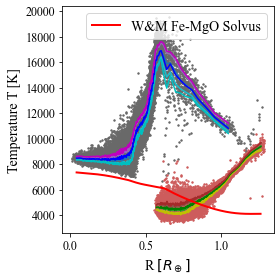

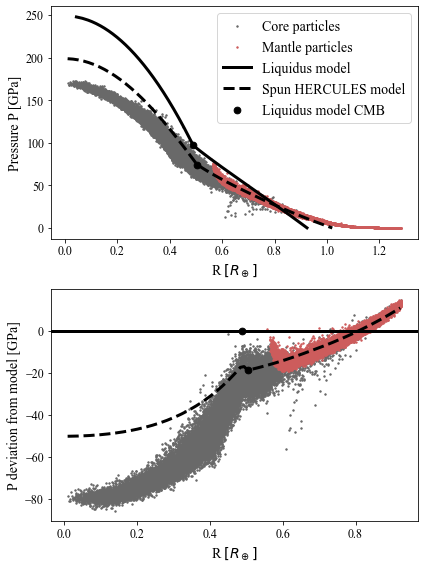

In [48]:
plot_IE_gain(data0, data, bcm, bvcm, pos, vel, index=indbnd, rplanet=rplanet, basename=basename)

## Figure 14

In [53]:
from matplotlib import cm

def Pvalue_HERC_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,FF=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    count=0
    allQS=np.array([])
    allmass=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    allHERC=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        HERCs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mplanet[-1]
            fPs[j] = (sim.P_CMBrubie*fp)/1.e9
            fPs1[j] = (sim.P_CMBrubie*1)/1.e9
            HERCs[j] = sim.HERC_PCMB/1.e9
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
            allHERC=np.append(allHERC,HERCs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allQS = allQS[index]
    allfP = allfP[index]
    allfP1 = allfP1[index]
    hercdex = np.isfinite(allHERC)
    hercmass = allmass[hercdex]
    allHERC = allHERC[hercdex]
    allmass = allmass[index]
    QSsort = np.argsort(allQS)
    masssort = np.argsort(allmass)
    polydeg = 4
    fP1fit,cov = np.polyfit(np.log10(allmass),allfP1,polydeg,cov=True)
    pfP1fit = np.poly1d(fP1fit)
    HERCfit,cov = np.polyfit(np.log10(hercmass),allHERC,polydeg,cov=True)
    pHERCfit = np.poly1d(HERCfit)
    fPfit,cov = np.polyfit(np.log10(allmass),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allmass)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allmass))
    chi2 = np.sum((resid / pfPfit(np.log10(allmass)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allmass)),np.amax(np.log10(allmass)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allmass), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: 
        if FF:
            FFCMBs=vCMB_rubie(logspace,0.3*logspace*M_earth,0.7*logspace*M_earth)
            FFs=vP_rubie(FFCMBs,FFCMBs,FFCMBs+1,logspace,0.3*logspace*M_earth,0.7*logspace*M_earth)/1.e9
            ax.plot(logspace,FFs,color='k',lw=2,label='Fixed-fraction static sub-liquidus CMB')
            ax.plot(logspace,FFs*fp,ls='--',color='k',lw=2,label='Fixed-fraction empirical pressure model')
            ax.scatter(hercmass,allHERC,marker='o',color='red',s=20,label='Rotating sub-liquidus data')
        else:
            ax.plot(logspace,pfP1fit(np.log10(logspace)),color='k',lw=2,label='Static sub-liquidus CMB')
            ax.plot(logspace,pfPfit(np.log10(logspace)),ls='--',color='k',lw=2,label='Static empirical pressure model')
        #ax.plot(logspace,pHERCfit(np.log10(logspace)),ls='--',color='red',lw=2,label='Rotating sub-liquidus CMB')
    #if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allmass[masssort],allfP1[masssort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allmass[masssort],allfP[masssort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.P_CMBrubie*100
            DPplanets[j] = (sim.PCMB25)/1.e9
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            masses[j] = sim.Mplanet[-1]
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(masses[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(masses[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(masses)),np.amax(np.log10(masses)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            ax.scatter(masses,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
            
    if fp !=1:
        ax.legend()
    if (colors is not None) and (show==True):
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*')#,size=22
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]')#,size=22
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=22
    ax.set_xlabel(r'Planet Mass [$M_\oplus$]')#,size=24
    ax.set_ylabel('CMB Pressure [GPa]')#,size=24
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    ax.set_yscale('log')
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()
    
def Pvalue_HERC_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,FF=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    count=0
    allQS=np.array([])
    allmass=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    allHERC=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        HERCs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            masses[j] = sim.Mplanet[-1]
            fPs[j] = (sim.P_CMBrubie*fp)/1.e9
            fPs1[j] = (sim.P_CMBrubie*1)/1.e9
            HERCs[j] = sim.HERC_PCMB/1.e9
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allmass=np.append(allmass,masses[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
            allHERC=np.append(allHERC,HERCs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allfP = allfP[index]
    allfP1 = allfP1[index]
    hercdex = np.isfinite(allHERC)
    hercQS = allQS[hercdex]
    allQS = allQS[index]
    allHERC = allHERC[hercdex]
    allmass = allmass[index]
    QSsort = np.argsort(allQS)
    masssort = np.argsort(allmass)
    polydeg = 4
    fP1fit,cov = np.polyfit(np.log10(allQS),allfP1,polydeg,cov=True)
    pfP1fit = np.poly1d(fP1fit)
    HERCfit,cov = np.polyfit(np.log10(hercQS),allHERC,polydeg,cov=True)
    pHERCfit = np.poly1d(HERCfit)
    fPfit,cov = np.polyfit(np.log10(allQS),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allmass)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allQS))
    chi2 = np.sum((resid / pfPfit(np.log10(allQS)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allQS)),np.amax(np.log10(allQS)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: 
        ax.plot(logspace,pfP1fit(np.log10(logspace)),color='k',lw=2,label='Static sub-liquidus CMB')
        ax.plot(logspace,pfPfit(np.log10(logspace)),ls='--',color='k',lw=2,label='Static empirical pressure model')
        ax.plot(logspace,pHERCfit(np.log10(logspace)),ls='--',color='red',lw=2,label='Rotating sub-liquidus CMB')
    ax.scatter(hercQS,allHERC,marker='o',color='red',s=20,label='Rotating sub-liquidus data')
    #if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allQS[QSsort],allfP1[QSsort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allQS[QSsort],allfP[QSsort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        masses=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMB25)/1.e9
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            masses[j] = sim.Mplanet[-1]
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            fitind = np.where(DPplanets>0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                
    if fp !=1:
        ax.legend()#fontsize=18
    if (colors is not None) and (show==True):
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*')#,size=22
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]')#,size=22
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=22
    ax.set_xlabel(r'Specific Impact Energy $Q_S$ (J/kg)')#,size=22
    ax.set_ylabel('CMB Pressure [GPa]')#,size=24
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    ax.set_yscale('log')
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()


### Panel a

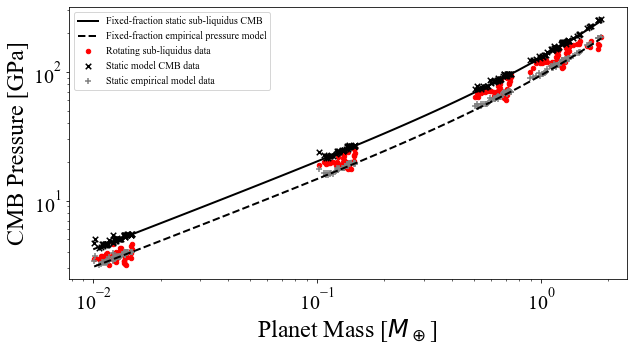

In [54]:
#%matplotlib inline
Pvalue_HERC_mass([accretionlist,partialaccretionlist],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=True,fill=True,FF=True)

### Panel **b**

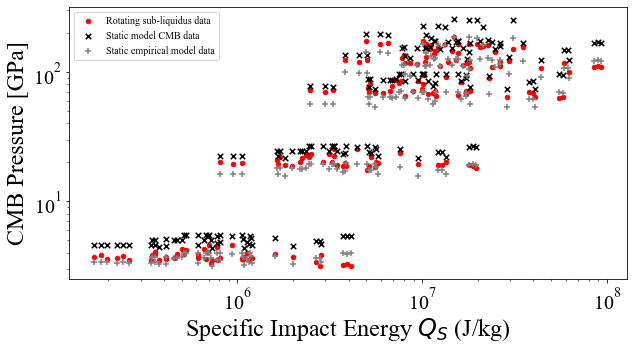

In [55]:
Pvalue_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False)#,savefig='Pvalue_QS'

## Figure 15

In [65]:
from matplotlib import cm

def P_rubie_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,line=True,rotating=False,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        DProtating=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        alpha=0
        if show: alpha=1
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMB25 - sim.P_CMBrubie)/sim.P_CMBrubie*100
            DProtating[j] = (sim.HERC_PCMB - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                if plain: 
                    if count==0: 
                        ax.scatter(QSs[j],0,s=30,c='black',marker='x',label='Static model CMB data')
                        if fp != 1: ax.scatter(QSs[j],(-1+fp)*100,s=30,c='grey',marker='+',label='Static empirical model data')
                    else:
                        ax.scatter(QSs[j],0,s=30,c='black',marker='x')
                        if fp != 1: ax.scatter(QSs[j],(-1+fp)*100,s=30,c='grey',marker='+')
                if rotating:
                    if count==0:
                        ax.scatter(QSs[j],DProtating[j],s=30,c='red',label='Rotating sub-liquidus data')
                    else:
                        ax.scatter(QSs[j],DProtating[j],s=30,c='red')
                count+=1
        if logfit:
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
            if plain: 
                ax.scatter(QSs,0,s=30,c='black',marker='+')
                if fp != 1: ax.scatter(QSs,(-1+fp)*100,s=30,c='grey',marker='x')
                
    if line:
        ax.axhline(y=0, color='k',lw=3,label='Static sub-liquidus model CMB')
        ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Empirical pressure model')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if (colors is not None): #and (show==True)
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('Percent P deviation from static model',size=24)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def P_HERC_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,logfit=False,fp=1,show=True,plain=False,fit=True,fill=True,savefig=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfP=np.array([])
    allfP1=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        fPs=np.zeros(np.size(simlist))
        fPs1=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            fPs[j] = (sim.P_CMBrubie*fp-sim.HERC_PCMB)/sim.HERC_PCMB*100
            fPs1[j] = (sim.P_CMBrubie*1-sim.HERC_PCMB)/sim.HERC_PCMB*100
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
            allfP=np.append(allfP,fPs[j])
            allfP1=np.append(allfP1,fPs1[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    alpha=0
    if show: alpha=1
    index = np.isfinite(allfP)
    allQS = allQS[index]
    allfP = allfP[index]
    allfP1 = allfP1[index]
    QSsort = np.argsort(allQS)
    polydeg = 3
    fPfit,cov = np.polyfit(np.log10(allQS),allfP,polydeg,cov=True)
    pfPfit = np.poly1d(fPfit)
    n = np.size(allQS)
    m = polydeg+1
    dof = n-m
    t1 = scipy.stats.t.ppf(0.9999, n - m)
    t2 = scipy.stats.t.ppf(0.001, n - m)
    resid = allfP - pfPfit(np.log10(allQS))
    chi2 = np.sum((resid / pfPfit(np.log10(allQS)))**2,dtype='float64')
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)
    logspace=np.logspace(np.amin(np.log10(allQS)),np.amax(np.log10(allQS)),base=10)
    ci1=find_ci_manual(t1, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    ci2=find_ci_manual(t2, s_err, n, np.log10(allQS), np.log10(logspace), pfPfit(np.log10(logspace)))
    if fit: ax.plot(allQS[QSsort],pfPfit(np.log10(allQS[QSsort])),ls='--',color='k',lw=2,label='Static empirical pressure model')
    if fill: ax.fill_between(logspace,pfPfit(np.log10(logspace))+2.5*ci1,pfPfit(np.log10(logspace))+2.5*ci2, color='#b9cfe7')
    if plain: ax.scatter(allQS[QSsort],allfP1[QSsort],marker='x',color='black',s=30,label='Static model CMB data')
    ax.scatter(allQS[QSsort],allfP[QSsort],marker='+',color='gray',s=30,label='Static empirical model data')
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            #DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            DPplanets[j] = (sim.PCMB25 - sim.HERC_PCMB)/sim.HERC_PCMB*100
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm,alpha=alpha)#label=sim.label,
                else:
                    ax.scatter(QSs[j],DPplanets[j],s=35,marker=marker,alpha=alpha)#label=sim.label,
                count+=1
        if logfit:
            fitind = np.where(DPplanets<0)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs[fitind]),np.log10(-DPplanets[fitind]),logfit,full=True)
            #allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(-DPplanets[fitind])-np.mean(np.log10(-DPplanets[fitind])))**2))
            fitfn=np.poly1d(fit)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),base=10)
            ax.plot(logspace,-np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker,alpha=alpha)
                
    ax.axhline(y=0, color='red',lw=3,label='Rotating sub-liquidus CMB')
    if fp !=1:
        ax.legend(fontsize=20)
    #ax.axhline(y=(-1+fp)*100,ls='--',color='k',lw=2,label='Adjusted for fP')
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if (colors is not None): #and (show==True)
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('Planet Lz/L*',size=22)
            else:cbar.set_label(r'Planet $L_Z$ [$L_{EM}$]',size=22)
        if colors=='QS':cbar.set_label('QS [J/kg]',size=22)
    ax.set_xlabel(r'Specific Impact Energy $Q_S$ (J/kg)',size=24)
    ax.set_ylabel('%P deviation from rotating model',size=24)
    
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()


### Panel **a**

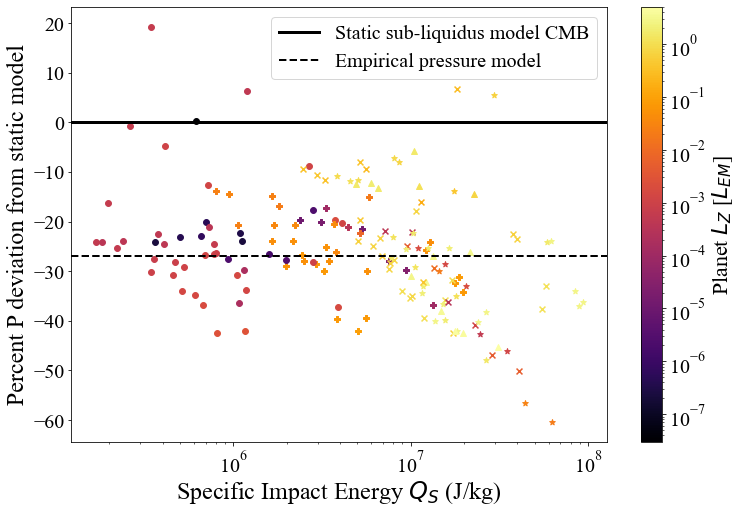

In [62]:
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73)#,savefig='hercules_a'

### Panel **b**

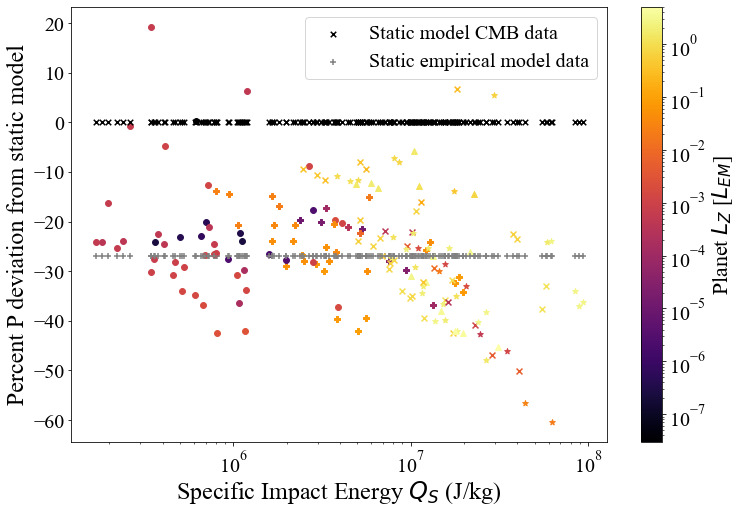

In [63]:
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,plain=True,line=False)#,savefig='hercules_b'

### Panel **c**

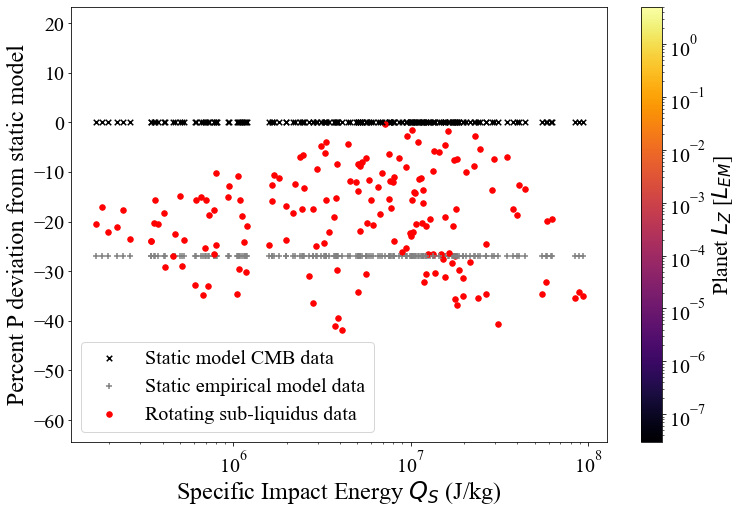

In [66]:
P_rubie_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,line=False,rotating=True)#,savefig='hercules_c'

### Panel **d**

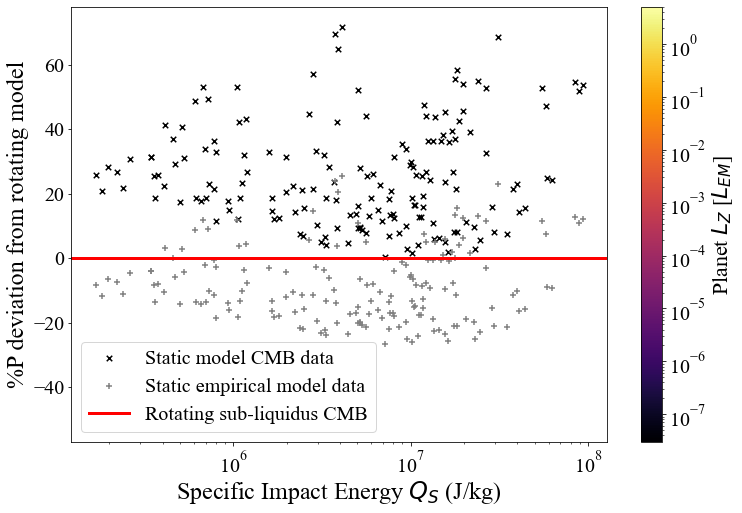

In [67]:
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=True,fit=False,fill=False)#,savefig='hercules_d'

### Panel **e**

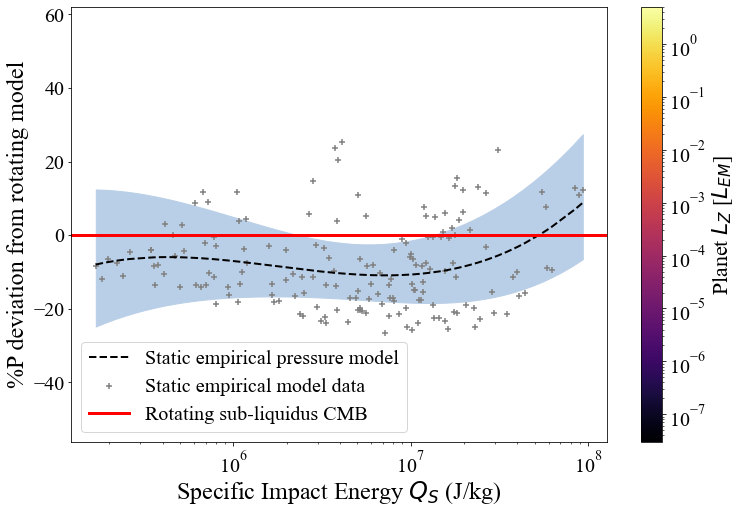

In [68]:
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73,show=False,plain=False,fit=True,fill=True)#,savefig='hercules_e'

### Panel **d**

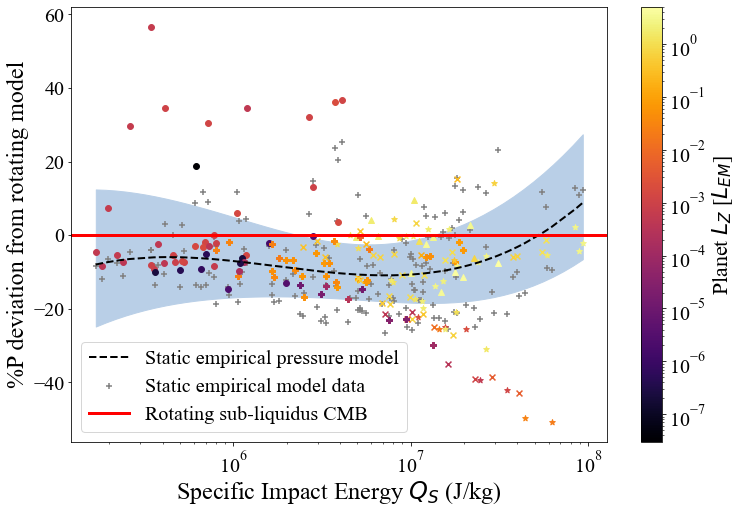

In [69]:
P_HERC_QS([accretionlistno90,partialaccretionlistno90],labels=None,colors='Lz',legend=False,markers='size',fp=.73)#,savefig='hercules_f'

# Appendix
## Appendix Figure 16

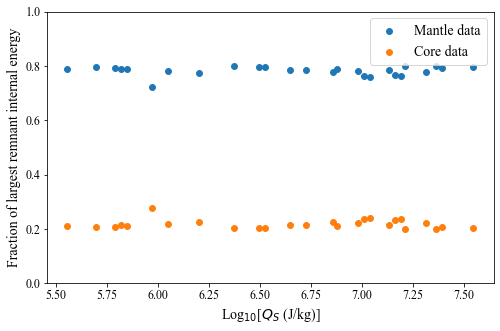

In [71]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
#matplotlib.rc('xlabel', fontsize=14)
#matplotlib.rc('ylabel', fontsize=14)
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["figure.facecolor"] = 'white'
#mpl.rcParams["axes.facecolor"] 
plt.rcParams["savefig.facecolor"]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize':14})

QS_u_core_mantle_fraction([accretion010list],labels=None)

## Appendix Figure 17

Mantle polynomial coefficients, n...0 :  [-0.24500346  1.08140037]
Mantle R^2 value:  [0.91454562]
Mantle error:  [0.04457369]
Mantle percent error:  [0.09754344] *100
Core polynomial coefficients, n...0 :  [-0.24613151  0.53246584]
Core R^2 value:  [0.96527443]
Core error:  [0.02778487]
Core percent error:  [0.06197346] *100


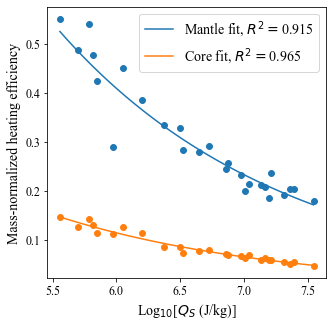

In [72]:
u_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

# Supplementary Figures

In [77]:
def QS_ICs_vi(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        vi=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            vi[j] = sim.vi
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(vi),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,vi,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')#,fontsize=20
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=18
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]')#,size=18
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=18
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]')#,size=22
        ax.set_ylabel(r'Log[$[v/v_{esc}]$]')#,size=22
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=22
        ax.set_ylabel(r'$[v/v_{esc}]$')#,size=22
    ax.set_ylim(.9,None)
    plt.grid(visible=True)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()

def QS_ICs_theta(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False,savefig=None):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    fig,ax=plt.subplots(1,1,figsize=(8,5))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        theta=np.zeros(np.size(simlist))
        count=0
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.HERC_Lz/sim.Lzstar
            else: Lzs[j]=sim.HERC_Lz
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            theta[j] = sim.theta
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(theta),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,theta,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')#,fontsize=20
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*')#,size=18
            else:cbar.set_label(r'$Bound L_{Z}$ [$L_{EM}$]')#,size=18
        if colors=='QS':cbar.set_label('QS [J/kg]')#,size=18
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J/kg)]')#,size=22
        ax.set_ylabel('Log[Impact angle (degrees)]')#,size=22
    else:
        ax.set_xlabel('Specific Impact Energy $Q_S$ (J/kg)')#,size=22
        ax.set_ylabel('Impact angle (degrees)')#,size=22
    ax.set_ylim(-5,None)
    plt.grid(visible=True)
    if savefig is not None:
        imname=savefig+'.pdf'
        plt.savefig(imname,bbox_inches='tight')
    plt.show()


## Supplementary Figure 18

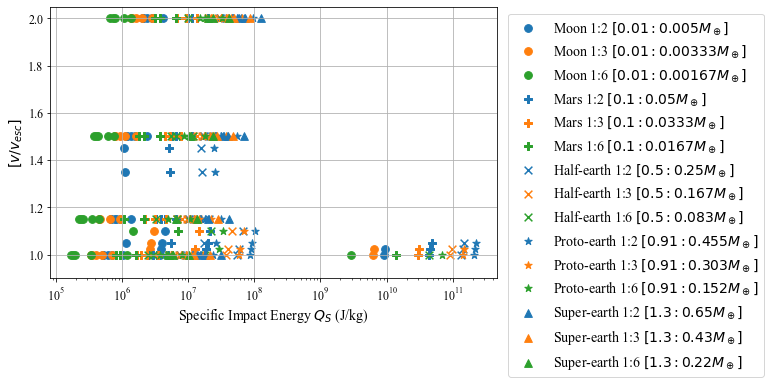

In [75]:
QS_ICs_vi(massandratiolist,labels=massandratiolabels)

## Supplementary Figure 19

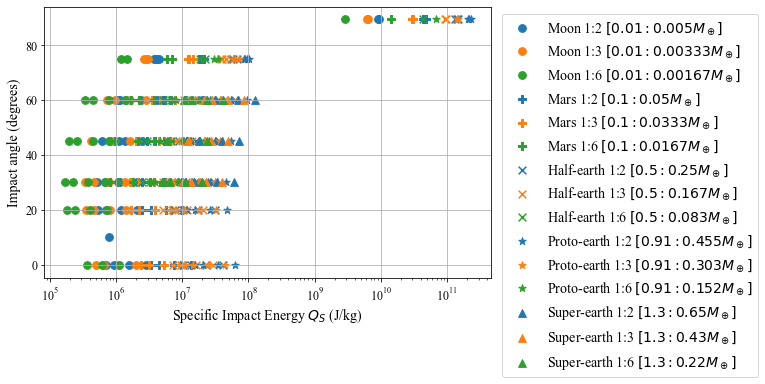

In [78]:
QS_ICs_theta(massandratiolist,labels=massandratiolabels)

## Supplementary Figure 22

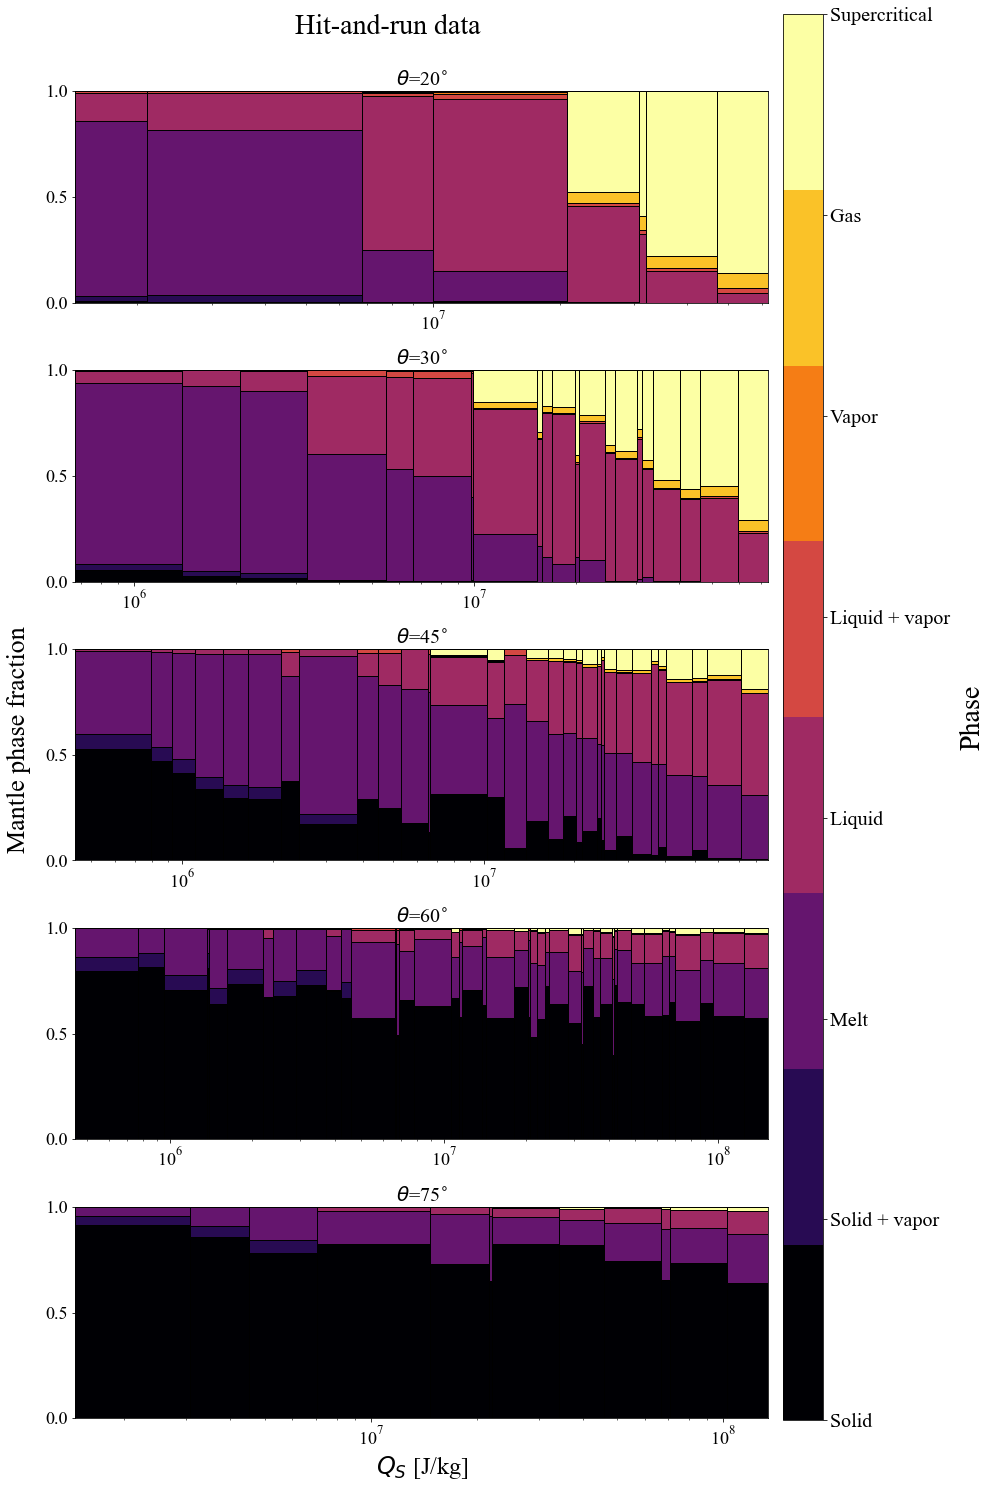

In [82]:
mantle_phase_bar_combined([hitandrunlist],markers='size',labels=None,title='Hit-and-run data')#,savefig='melt_frac_hnr'